In [3]:
import sys
import os

# Adjust the path as needed to reach your project root from the notebook's location
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

project_root

'/Users/peterfalterbaum/Documents/Nova/thesis local/implementation/public_implementation'

In [4]:
from config import PROJECT_ROOT
from pathlib import Path

In [ ]:
import os
import json
import pandas as pd
from pathlib import Path

EXPORT_FLAG = True

# Get the decomposition file path
# decomposition_path_weekday = str(PROJECT_ROOT) + "/data/results/decompositions/CP/final/peak hours normalized/utrecht/odt_no_same_od_no_rare_od_fixed_thresh_normalizedPeaks/odt_utrecht_hourly_weekday/run_20250610_001409/rank_5/odt_processed_utrecht_hourly_weekday_factors.npz"

# decomposition_path_weekend = str(PROJECT_ROOT) + "/data/results/decompositions/CP/final/peak hours normalized/utrecht/odt_no_same_od_no_rare_od_fixed_thresh_normalizedPeaks/odt_utrecht_hourly_weekend/run_20250610_001322/rank_4/odt_processed_utrecht_hourly_weekend_factors.npz"

decomposition_path_weekday = str(
    PROJECT_ROOT) + "/data/results/decompositions/CP/final/peak hours normalized/rotterdam/odt_no_same_od_no_rare_od_fixed_thresh_normalizedPeaks/odt_rotterdam_hourly_weekday/run_20250610_001727/rank_6/odt_processed_rotterdam_hourly_weekday_factors.npz"

decomposition_path_weekend = str(
    PROJECT_ROOT) + "/data/results/decompositions/CP/final/peak hours normalized/rotterdam/odt_no_same_od_no_rare_od_fixed_thresh_normalizedPeaks/odt_rotterdam_hourly_weekend/run_20250610_001652/rank_6/odt_processed_rotterdam_hourly_weekend_factors.npz"


def get_decomposition_data(decomposition_path, granularity):
    # Extract the parent directory (rank_5 folder) and go up to the run directory
    run_dir = Path(decomposition_path).parent.parent

    # Read the run_summary.json file to get the tensor path
    run_summary_path = run_dir / "run_summary.json"
    if not run_summary_path.exists():
        raise FileNotFoundError(
            f"Run summary file not found: {run_summary_path}")

    with open(run_summary_path, 'r') as f:
        run_summary = json.load(f)

    # Extract the tensor file path from the run summary
    tensor_file_path = run_summary["tensor_info"]["file"]
    tensor_dir = Path(tensor_file_path).parent

    # Load the tensor decomposition factors
    factors_data = np.load(decomposition_path, allow_pickle=True)
    # Assuming the first factor matrix corresponds to origins and the second to destinations
    origin_factor = factors_data['factors'][0]
    destination_factor = factors_data['factors'][1]
    time_factor = factors_data['factors'][2]

    # Load the index mapping file (should be in the same directory as the tensor)
    if "utrecht" in tensor_file_path:
        index_mapping_path = tensor_dir / \
            f"index_mappings_utrecht_{granularity.lower()}_hourly.json"
    elif "rotterdam" in tensor_file_path:
        index_mapping_path = tensor_dir / \
            f"index_mappings_rotterdam_{granularity.lower()}_hourly.json"
    else:
        raise ValueError(f"Unknown city: {tensor_file_path.name}")

    with open(index_mapping_path, 'r') as f:
        index_mappings = json.load(f)

    # Get the mapping from index to postal code for origins and destinations
    idx_to_origins = index_mappings['idx_to_origins']
    idx_to_destinations = index_mappings['idx_to_destinations']

    return origin_factor, destination_factor, time_factor, idx_to_origins, idx_to_destinations


# Get the decomposition filename to extract granularity
# decomposition_filename = Path(decomposition_path).name
# Extract granularity from filename (e.g., "weekday" from "odt_processed_utrecht_hourly_weekday_factors.npz")
# granularity = decomposition_filename.split('_')[-2]  # Gets "weekday"

# # Construct the metadata file path using the known format in the tensor directory
# if "utrecht" in tensor_file_path:
#     metadata_filename = f"odt_processed_utrecht_hourly_{granularity}_metadata.json"
# elif "rotterdam" in tensor_file_path:
#     metadata_filename = f"odt_processed_rotterdam_hourly_{granularity}_metadata.json"
# else:
#     raise ValueError(f"Unknown city: {tensor_file_path.name}")

# metadata_path = tensor_dir / metadata_filename

# # Check if the metadata file exists
# if not metadata_path.exists():
#     raise FileNotFoundError(f"Metadata file not found: {metadata_path}")

# # Read the metadata file to get the source file path
# with open(metadata_path, 'r') as f:
#     metadata = json.load(f)

# # Extract the source file path from metadata
# source_file_path = metadata["source_file"]

# Load the original CSV data
# full_original_data = pd.read_csv(source_file_path)


full_original_data = pd.read_csv(
    str(PROJECT_ROOT) + "/data/processed/purpose_person_odt_no_same_od_no_rare_od.csv")

In [6]:
import os
import logging
from matplotlib.figure import Figure

base_path = "/Users/peterfalterbaum/Documents/Nova/thesis local/writing/rocket_science/nova_ims_template/IMS_TEX/rocket_science_duplicate/graphics/results"
mode_path = os.path.join(base_path, "mode_analysis")
age_path = os.path.join(base_path, "age_analysis")
purpose_path = os.path.join(base_path, "purpose_analysis")


def save_plot(fig: Figure, feature: str, city: str) -> None:
    """
    Save a matplotlib Figure to a file with a given identifier.

    Args:
        fig (Figure): A matplotlib.figure.Figure instance.
        feature (str): One of "mode", "age", "purpose".
        city (str): City name to include in filename.
        method (str): One of "baseline", "cp", "tucker".

    Raises:
        TypeError: if `fig` is not a Figure.
        ValueError: if `feature` or `method` are invalid.
    """
    method = "cp"
    if not isinstance(fig, Figure):
        raise TypeError("save_plot expects a matplotlib.figure.Figure")

    # choose directory by feature
    if feature == "mode":
        out_dir = mode_path
    elif feature == "age":
        out_dir = age_path
    elif feature == "purpose":
        out_dir = purpose_path
    else:
        raise ValueError(f"Invalid feature: {feature!r}")

    # choose filename by method
    if method == "baseline":
        fname = f"{city}_baseline.png"
    elif method == "cp":
        fname = f"{city}_cp_patterns.png"
    elif method == "tucker":
        fname = f"{city}_tucker_patterns.png"
    else:
        raise ValueError(f"Invalid method: {method!r}")

    # ensure output directory exists
    os.makedirs(out_dir, exist_ok=True)

    file_path = os.path.join(out_dir, fname)
    if EXPORT_FLAG:
        try:
            fig.savefig(file_path, bbox_inches="tight")
            logging.info(f"Plot saved as {file_path}")
        except OSError as e:
            logging.error(f"OS error when saving plot: {e}")
    else:
        logging.info(f"Plot NOT saved as {file_path}")

# Add-ons


In [7]:
# Convert all columns starting with "pc4_" to string type
pc4_columns = [
    col for col in full_original_data.columns if col.startswith('pc4_')]
for col in pc4_columns:
    full_original_data[col] = full_original_data[col].astype(str)

full_original_data

,pc4_arrival,pc4_departure,timestamp_departure,timestamp_arrival,mode_of_transport,destination/purpose,motive,class_division_motif,age_op,postal_code_residential_address
0,1746,1742,2022-11-28 08:45:00,2022-11-28 08:55:00,1,11,10,7,76,1742
1,6511,6542,2022-10-04 13:30:00,2022-10-04 13:40:00,5,2,1,1,83,6542
2,6542,6511,2022-10-04 18:00:00,2022-10-04 18:10:00,5,1,8,6,83,6542
3,6511,6542,2022-10-04 19:00:00,2022-10-04 19:10:00,5,12,11,7,83,6542
4,6542,6511,2022-10-04 21:00:00,2022-10-04 21:08:00,5,1,11,7,83,6542
...,...,...,...,...,...,...,...,...,...,...
60082,3401,3403,2022-02-05 08:00:00,2022-02-05 08:06:00,6,8,7,4,63,3403
60083,3403,3401,2022-02-05 08:26:00,2022-02-05 08:33:00,6,1,7,4,63,3403
60084,3403,3401,2022-02-05 14:20:00,2022-02-05 14:25:00,5,1,7,4,63,3403
60085,1509,1506,2022-12-08 18:20:00,2022-12-08 18:35:00,1,11,10,7,49,1506


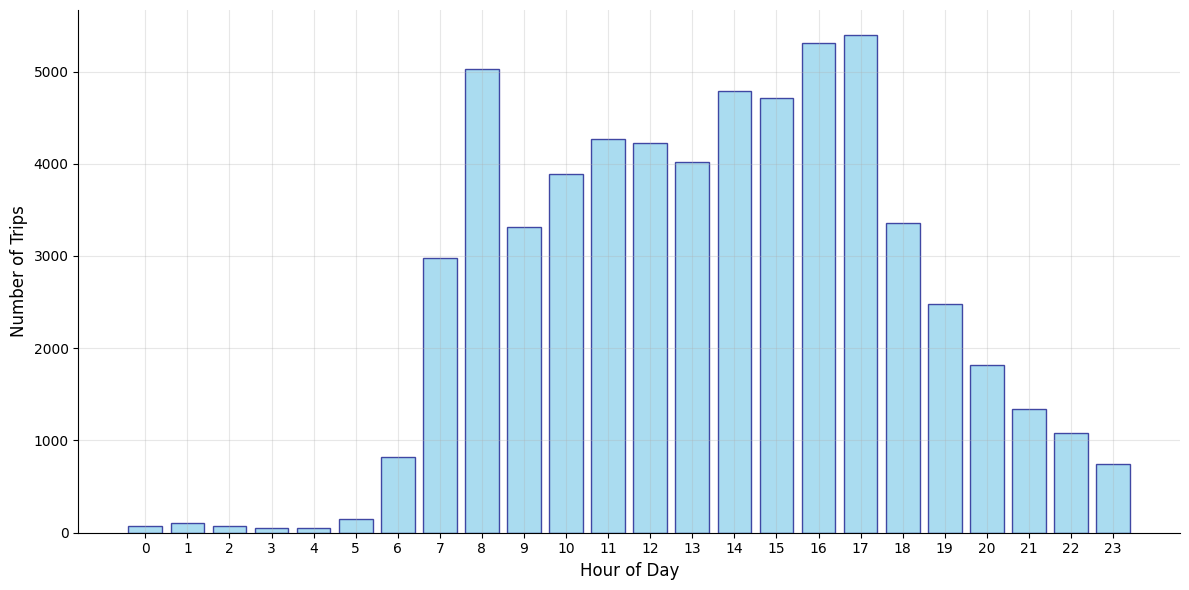

Total trips: 60087
Peak hour: 17 (with 5397 trips)
Lowest hour: 4 (with 53 trips)


In [8]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert timestamp_departure to datetime and extract hour
data_to_plot = full_original_data.copy()
data_to_plot['hour_of_day'] = pd.to_datetime(
    data_to_plot['timestamp_departure'], format='%Y-%m-%d %H:%M:%S'
).dt.hour

# Count trips by hour
hourly_trips = data_to_plot['hour_of_day'].value_counts().sort_index()

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(hourly_trips.index, hourly_trips.values,
       alpha=0.7, color='skyblue', edgecolor='navy')

# Customize the plot
ax.set_xlabel('Hour of Day', fontsize=12)
ax.set_ylabel('Number of Trips', fontsize=12)
ax.grid(True, alpha=0.3)
ax.set_xticks(range(0, 24))

# Remove top and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# # Add value labels on bars
# for i, v in enumerate(hourly_trips.values):
#     ax.text(hourly_trips.index[i], v + max(hourly_trips.values) * 0.01,
#              str(v), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"Total trips: {len(data_to_plot)}")
print(f"Peak hour: {hourly_trips.idxmax()} (with {hourly_trips.max()} trips)")
print(
    f"Lowest hour: {hourly_trips.idxmin()} (with {hourly_trips.min()} trips)")

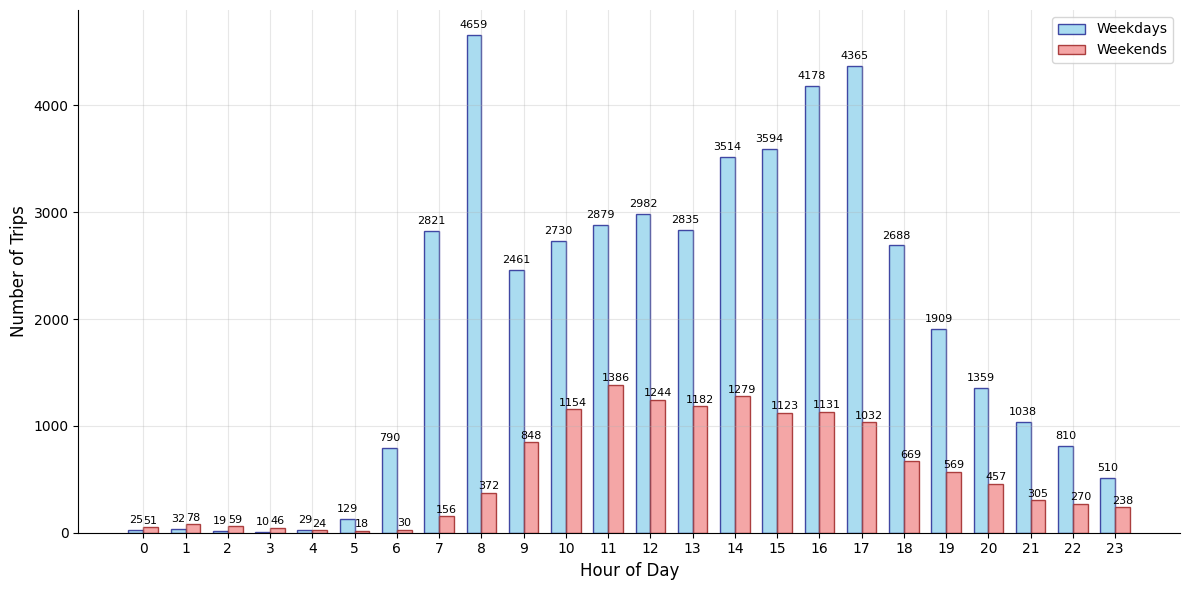

Total trips: 60087
Weekday trips: 46366
Weekend trips: 13721
Weekday peak hour: 8 (with 4659 trips)
Weekend peak hour: 11 (with 1386 trips)
Weekday lowest hour: 3 (with 10 trips)
Weekend lowest hour: 5 (with 18 trips)


In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Convert timestamp_departure to datetime and extract hour and day of week
data_to_plot = full_original_data.copy()
data_to_plot['timestamp'] = pd.to_datetime(
    data_to_plot['timestamp_departure'], format='%Y-%m-%d %H:%M:%S'
)
data_to_plot['hour_of_day'] = data_to_plot['timestamp'].dt.hour
data_to_plot['day_of_week'] = data_to_plot['timestamp'].dt.dayofweek

# Separate weekday and weekend data
# Monday = 0, Friday = 4
weekday_data = data_to_plot[data_to_plot['day_of_week'] < 5]
# Saturday = 5, Sunday = 6
weekend_data = data_to_plot[data_to_plot['day_of_week'] >= 5]

# Count trips by hour for weekdays and weekends
weekday_hourly_trips = weekday_data['hour_of_day'].value_counts().sort_index()
weekend_hourly_trips = weekend_data['hour_of_day'].value_counts().sort_index()

# Ensure both series have all hours (0-23)
all_hours = range(24)
weekday_hourly_trips = weekday_hourly_trips.reindex(all_hours, fill_value=0)
weekend_hourly_trips = weekend_hourly_trips.reindex(all_hours, fill_value=0)

# Create combined chart
fig, ax = plt.subplots(figsize=(12, 6))

# Set up bar positions
x = np.arange(24)
width = 0.35

# Create grouped bars
weekday_bars = ax.bar(x - width/2, weekday_hourly_trips.values, width,
                      label='Weekdays', alpha=0.7, color='skyblue', edgecolor='navy')
weekend_bars = ax.bar(x + width/2, weekend_hourly_trips.values, width,
                      label='Weekends', alpha=0.7, color='lightcoral', edgecolor='darkred')

# Customize the plot
ax.set_xlabel('Hour of Day', fontsize=12)
ax.set_ylabel('Number of Trips', fontsize=12)
# ax.set_title('Number of Trips by Hour of Day - Weekdays vs Weekends', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(range(24))
ax.legend()
ax.grid(True, alpha=0.3)

# Remove top and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add value labels on bars
for i, (weekday_val, weekend_val) in enumerate(zip(weekday_hourly_trips.values, weekend_hourly_trips.values)):
    if weekday_val > 0:
        ax.text(i - width/2, weekday_val + max(weekday_hourly_trips.values) * 0.01,
                str(weekday_val), ha='center', va='bottom', fontsize=8)
    if weekend_val > 0:
        ax.text(i + width/2, weekend_val + max(weekend_hourly_trips.values) * 0.01,
                str(weekend_val), ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"Total trips: {len(data_to_plot)}")
print(f"Weekday trips: {len(weekday_data)}")
print(f"Weekend trips: {len(weekend_data)}")
print(
    f"Weekday peak hour: {weekday_hourly_trips.idxmax()} (with {weekday_hourly_trips.max()} trips)")
print(
    f"Weekend peak hour: {weekend_hourly_trips.idxmax()} (with {weekend_hourly_trips.max()} trips)")
print(
    f"Weekday lowest hour: {weekday_hourly_trips.idxmin()} (with {weekday_hourly_trips.min()} trips)")
print(
    f"Weekend lowest hour: {weekend_hourly_trips.idxmin()} (with {weekend_hourly_trips.min()} trips)")

In [10]:
import numpy as np

origin_factor, destination_factor, time_factor, idx_to_origins, idx_to_destinations = get_decomposition_data(
    decomposition_path_weekday, "weekday")


# Get the set of postal codes used in the tensor
origin_postal_codes = set(idx_to_origins.values())
destination_postal_codes = set(idx_to_destinations.values())
all_postal_codes = origin_postal_codes.union(destination_postal_codes)


def get_filtered_data(full_original_data, all_postal_codes, granularity):
    # Filter the CSV data to only include rows where origin or destination is in the tensor postal codes
    # and filter by weekday/weekend based on granularity
    filtered_data = None
    if granularity == 'weekday':
        # Filter for weekdays only (Monday = 0, Tuesday = 1, ..., Friday = 4)
        filtered_data = full_original_data[
            full_original_data['pc4_arrival'].isin(all_postal_codes) &
            full_original_data['pc4_departure'].isin(all_postal_codes) &
            (pd.to_datetime(
                full_original_data['timestamp_departure']).dt.weekday < 5)
        ]
    elif granularity == 'weekend':
        # Filter for weekends only (Saturday = 5, Sunday = 6)
        filtered_data = full_original_data[
            full_original_data['pc4_arrival'].isin(all_postal_codes) &
            full_original_data['pc4_departure'].isin(all_postal_codes) &
            (pd.to_datetime(
                full_original_data['timestamp_departure']).dt.weekday >= 5)
        ]
    return filtered_data


filtered_data_weekday = get_filtered_data(
    full_original_data, all_postal_codes, "weekday")
filtered_data_weekend = get_filtered_data(
    full_original_data, all_postal_codes, "weekend")
filtered_datasets = [filtered_data_weekday, filtered_data_weekend]

full_filtered_data = full_original_data[
    full_original_data['pc4_arrival'].isin(all_postal_codes) &
    full_original_data['pc4_departure'].isin(all_postal_codes)
]


# Now filtered_data contains only the rows relevant to the tensor's postal codes
print(f"Filtered data shape: {filtered_data_weekday.shape}")

Filtered data shape: (2528, 10)


In [11]:
# Map mode_of_transport values to their descriptions
mode_mapping = {
    1: "Car",
    2: "Car",
    3: "Train/Bus/Tram/Metro",
    4: "Train/Bus/Tram/Metro",
    5: "Bicycle",
    6: "On foot",
    7: "Other"
}

# Map trip_purpose values to their descriptions (reduced to 7 categories)
purpose_mapping = {
    1: "Home",
    2: "Work",  # Combines "To work", "Business visit in a working atmosphere", "Professionally"
    3: "Work",  # Combines "To work", "Business visit in a working atmosphere", "Professionally"
    4: "Work",  # Combines "To work", "Business visit in a working atmosphere", "Professionally"
    5: "Services",  # Combines "Pick up/drop off people", "Collect/deliver goods", "Services/personal care"
    6: "Services",  # Combines "Pick up/drop off people", "Collect/deliver goods", "Services/personal care"
    7: "Education",  # "Taking education/course"
    8: "Shopping",  # "Shopping/grocery shopping"
    9: "Leisure",  # Combines "Visitors/staying over", "Touring/hiking", "Sports/hobbies", "Other leisure activities"
    10: "Leisure",  # Combines "Visitors/staying over", "Touring/hiking", "Sports/hobbies", "Other leisure activities"
    11: "Leisure",  # Combines "Visitors/staying over", "Touring/hiking", "Sports/hobbies", "Other leisure activities"
    12: "Leisure",  # Combines "Visitors/staying over", "Touring/hiking", "Sports/hobbies", "Other leisure activities"
    13: "Services",  # Combines "Pick up/drop off people", "Collect/deliver goods", "Services/personal care"
    14: "Other"  # "Different purpose"
}

age_mapping_grid = {
    "0-20": "Kids/Teenager (<20)",
    "20-30": "Young Adults (20-30)",
    "30-40": "30es",
    "40-60": "Midaged (40-59)",
    "60-100": "Senior (>59)"
}

age_mapping = {}
for key in age_mapping_grid.keys():
    label = age_mapping_grid[key]
    start = int(str(key).split("-")[0])
    end = int(str(key).split("-")[1])
    for age in range(start, end):
        age_mapping[age] = label

In [12]:
for filtered_data in filtered_datasets:
    # Create a new column with the mapped mode descriptions
    filtered_data['mode_of_transport_desc'] = filtered_data['mode_of_transport'].map(
        mode_mapping)

    filtered_data['trip_purpose_desc'] = filtered_data['destination/purpose'].map(
        purpose_mapping)

    filtered_data['age_desc'] = filtered_data['age_op'].map(
        age_mapping)

    full_filtered_data['mode_of_transport_desc'] = full_filtered_data['mode_of_transport'].map(
        mode_mapping)
    full_filtered_data['trip_purpose_desc'] = full_filtered_data['destination/purpose'].map(
        purpose_mapping)
    full_filtered_data['age_desc'] = full_filtered_data['age_op'].map(
        age_mapping)

    # Display the mapping and some sample data
    print("Mode of transport mapping:")
    for code, desc in mode_mapping.items():
        print(f"{code}: {desc}")

    print("\nSample of data with mapped modes:")
    print(filtered_data[['mode_of_transport',
          'mode_of_transport_desc']].head(10))

    # Show distribution of modes
    print("\nDistribution of transport modes:")
    mode_counts = filtered_data['mode_of_transport_desc'].value_counts()
    print(mode_counts)

# # Verify the aggregation is working correctly
# print("\nVerification of aggregation:")
# print("Original mode counts:")
# original_counts = filtered_data['mode_of_transport'].value_counts().sort_index()
# print(original_counts)

# print("\nAggregated mode counts:")
# aggregated_counts = filtered_data['mode_of_transport_desc'].value_counts()
# print(aggregated_counts)

# # Verify that Car combines modes 1 and 2
# car_original = original_counts.get(1, 0) + original_counts.get(2, 0)
# car_aggregated = aggregated_counts.get("Car", 0)
# print(f"\nCar aggregation check: {car_original} (1+2) = {car_aggregated} (aggregated): {car_original == car_aggregated}")

# # Verify that Train/Bus/Tram/Metro combines modes 3 and 4
# pt_original = original_counts.get(3, 0) + original_counts.get(4, 0)
# pt_aggregated = aggregated_counts.get("Train/Bus/Tram/Metro", 0)
# print(f"Public transport aggregation check: {pt_original} (3+4) = {pt_aggregated} (aggregated): {pt_original == pt_aggregated}")

Mode of transport mapping:
1: Car
2: Car
3: Train/Bus/Tram/Metro
4: Train/Bus/Tram/Metro
5: Bicycle
6: On foot
7: Other

Sample of data with mapped modes:
     mode_of_transport mode_of_transport_desc
78                   4   Train/Bus/Tram/Metro
79                   4   Train/Bus/Tram/Metro
80                   4   Train/Bus/Tram/Metro
81                   4   Train/Bus/Tram/Metro
82                   4   Train/Bus/Tram/Metro
83                   4   Train/Bus/Tram/Metro
126                  7                  Other
164                  5                Bicycle
165                  5                Bicycle
191                  1                    Car

Distribution of transport modes:
mode_of_transport_desc
Train/Bus/Tram/Metro    872
Bicycle                 715
On foot                 461
Car                     425
Other                    55
Name: count, dtype: int64
Mode of transport mapping:
1: Car
2: Car
3: Train/Bus/Tram/Metro
4: Train/Bus/Tram/Metro
5: Bicycle
6: On foot
7: Ot

/var/folders/bj/r88z9c613s17r0cbp2t30cmm0000gn/T/ipykernel_7175/3299886253.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['mode_of_transport_desc'] = filtered_data['mode_of_transport'].map(
/var/folders/bj/r88z9c613s17r0cbp2t30cmm0000gn/T/ipykernel_7175/3299886253.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['trip_purpose_desc'] = filtered_data['destination/purpose'].map(
/var/folders/bj/r88z9c613s17r0cbp2t30cmm0000gn/T/ipykernel_7175/3299886253.py:9: SettingWithCopyW

/var/folders/bj/r88z9c613s17r0cbp2t30cmm0000gn/T/ipykernel_7175/3251258319.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_to_plot['hour_of_day'] = pd.to_datetime(
/var/folders/bj/r88z9c613s17r0cbp2t30cmm0000gn/T/ipykernel_7175/3251258319.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_to_plot['day_of_week'] = pd.to_datetime(


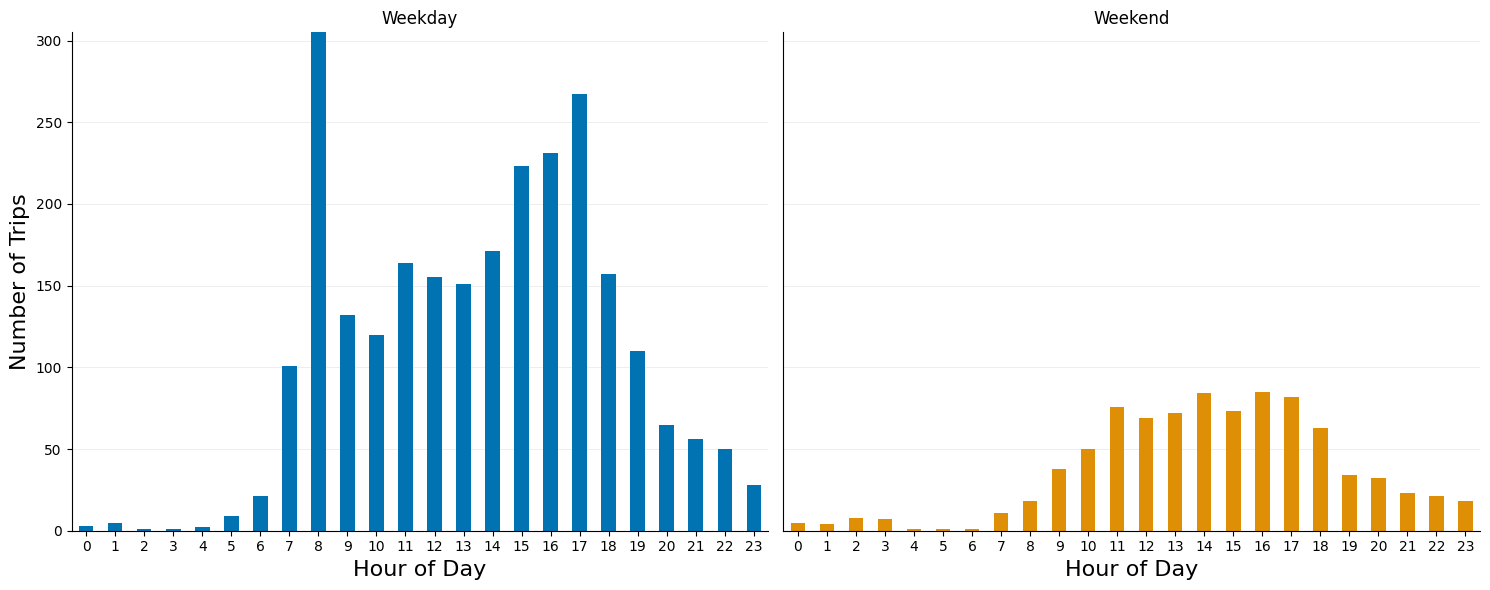

In [13]:
def plot_mode_of_transport_by_hour_bar(data_to_plot, y_column):
    # Create hour_of_day column from timestamp_departure
    data_to_plot['hour_of_day'] = pd.to_datetime(
        data_to_plot['timestamp_departure']).dt.hour

    # Create day of week column from timestamp_departure
    data_to_plot['day_of_week'] = pd.to_datetime(
        data_to_plot['timestamp_departure']).dt.dayofweek

    # Split data into weekday (0-4) and weekend (5-6)
    weekday_data = data_to_plot[data_to_plot['day_of_week'] < 5]
    weekend_data = data_to_plot[data_to_plot['day_of_week'] >= 5]

    # Plot the distribution of mode_of_transport over hour_of_day
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Create figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Get data for both plots
    weekday_hour_dist = weekday_data.groupby('hour_of_day').size()
    weekend_hour_dist = weekend_data.groupby('hour_of_day').size()

    # Find common y-axis limits
    y_max = max(weekday_hour_dist.max(), weekend_hour_dist.max())

    # Weekday plot
    weekday_hour_dist.plot(kind='bar', ax=ax1, color='#0173B2')
    ax1.set_xlabel('Hour of Day', fontsize=16)
    ax1.set_ylabel('Number of Trips', fontsize=16)
    ax1.set_title('Weekday')
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.set_ylim(0, y_max)

    # Add subtle grid lines
    ax1.yaxis.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    ax1.set_axisbelow(True)
    ax1.tick_params(axis='x', rotation=0)

    # ax2.text(0, -1.2, f'Weekend: n={weekend_total}', ha='center', va='center', fontsize=14)
    # Weekend plot
    weekend_hour_dist.plot(kind='bar', ax=ax2, color='#DE8F05')
    ax2.set_xlabel('Hour of Day', fontsize=16)
    ax2.set_ylabel('Number of Trips')
    ax2.set_title('Weekend')
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.set_ylim(0, y_max)
    ax2.tick_params(axis='x', rotation=0)

    # Remove y-axis labels and ticks from right plot
    ax2.set_ylabel('')
    ax2.tick_params(axis='y', left=False, labelleft=False)

    # Add subtle grid lines
    ax2.yaxis.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    ax2.set_axisbelow(True)

    plt.tight_layout()
    plt.show()

    # Print summary tables
    # print("Weekday trips by hour:")
    # print(weekday_hour_dist)
    # print("\nWeekend trips by hour:")
    # print(weekend_hour_dist)


plot_mode_of_transport_by_hour_bar(
    full_filtered_data, 'mode_of_transport_desc')

/var/folders/bj/r88z9c613s17r0cbp2t30cmm0000gn/T/ipykernel_7175/1406969527.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_to_plot['day_of_week'] = pd.to_datetime(


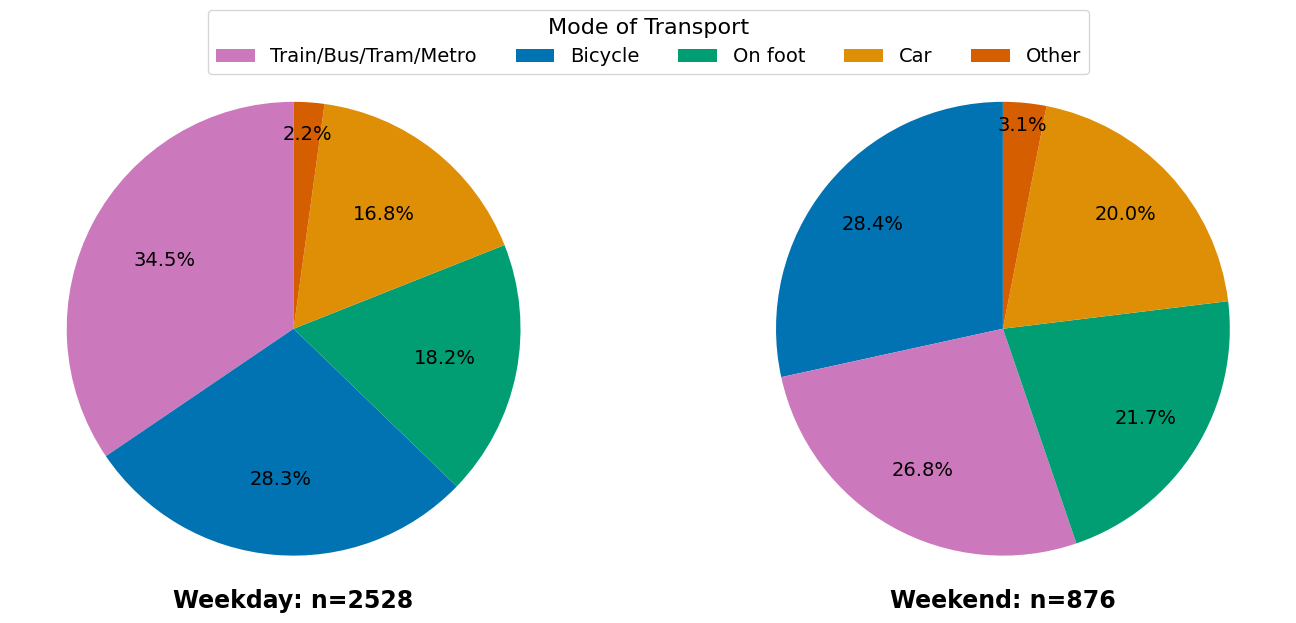

/var/folders/bj/r88z9c613s17r0cbp2t30cmm0000gn/T/ipykernel_7175/1406969527.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_to_plot['day_of_week'] = pd.to_datetime(


Weekday mode of transport distribution:
mode_of_transport_desc
Train/Bus/Tram/Metro    872
Bicycle                 715
On foot                 461
Car                     425
Other                    55
Name: count, dtype: int64

Weekend mode of transport distribution:
mode_of_transport_desc
Bicycle                 249
Train/Bus/Tram/Metro    235
On foot                 190
Car                     175
Other                    27
Name: count, dtype: int64


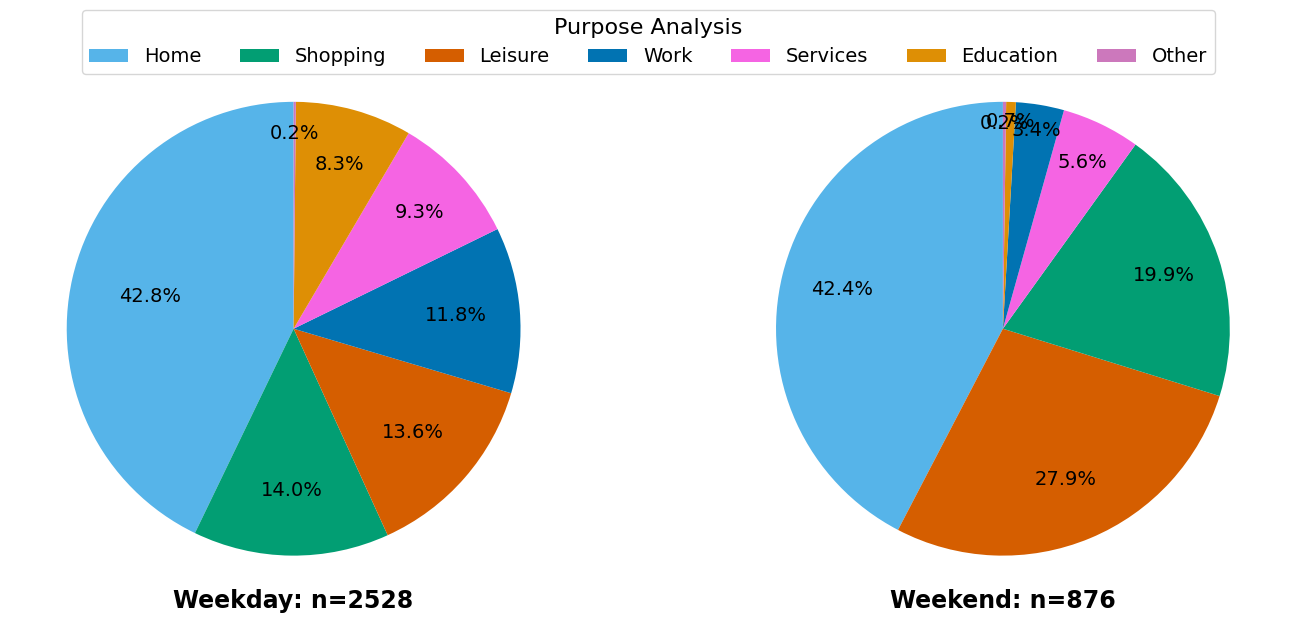

Weekday mode of transport distribution:
trip_purpose_desc
Home         1083
Shopping      353
Leisure       344
Work          299
Services      235
Education     210
Other           4
Name: count, dtype: int64

Weekend mode of transport distribution:
trip_purpose_desc
Home         371
Leisure      244
Shopping     174
Services      49
Work          30
Education      6
Other          2
Name: count, dtype: int64


/var/folders/bj/r88z9c613s17r0cbp2t30cmm0000gn/T/ipykernel_7175/1406969527.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_to_plot['day_of_week'] = pd.to_datetime(


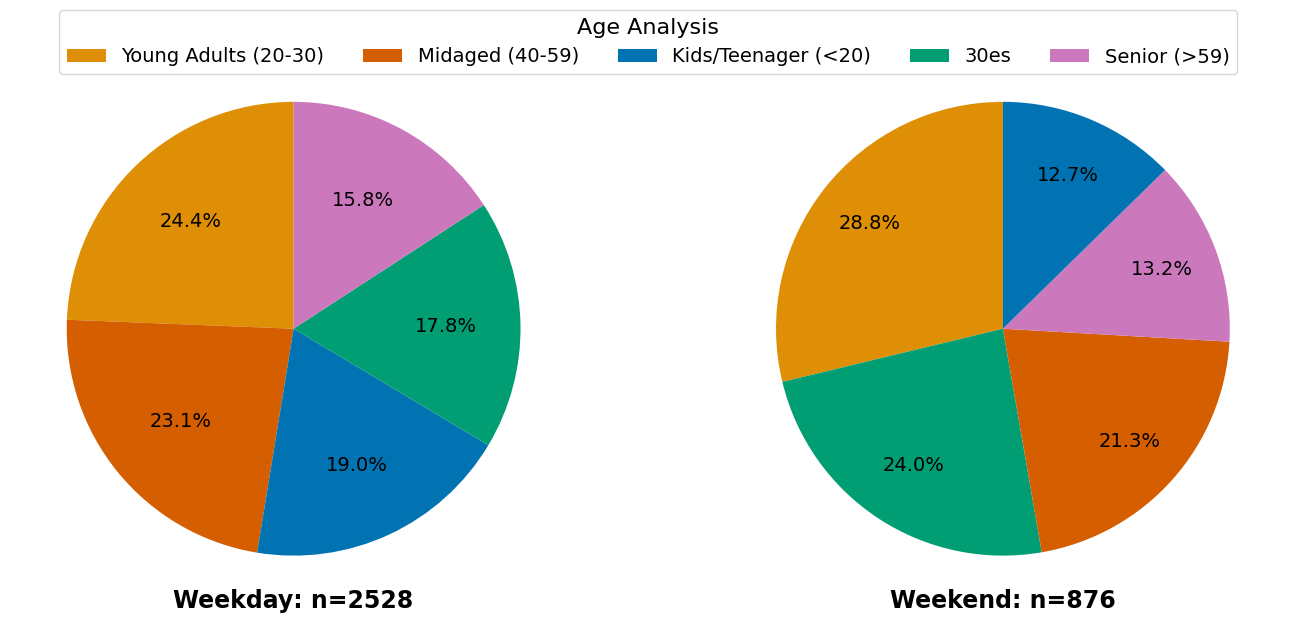

Weekday mode of transport distribution:
age_desc
Young Adults (20-30)    616
Midaged (40-59)         583
Kids/Teenager (<20)     480
30es                    449
Senior (>59)            400
Name: count, dtype: int64

Weekend mode of transport distribution:
age_desc
Young Adults (20-30)    252
30es                    210
Midaged (40-59)         187
Senior (>59)            116
Kids/Teenager (<20)     111
Name: count, dtype: int64


In [14]:
# Define color-blind friendly palette for mode of transport
mode_colors = {
    'Bicycle': '#0173B2',      # blue
    'Car': '#DE8F05',          # orange
    'On foot': '#029E73',      # green
    'Other': '#D55E00',        # red-orange
    'Train/Bus/Tram/Metro': '#CC78BC'  # pink
}

# Define color-blind friendly palette for mode of transport
purpose_colors = {
    'Work': '#0173B2',        # blue
    'Education': '#DE8F05',   # orange
    'Shopping': '#029E73',    # green
    'Leisure': '#D55E00',     # red-orange
    'Other': '#CC78BC',       # purple
    'Home': '#56B4E9',        # light blue
    'Services': '#F564E3',    # magenta (highly differentiable)
}

# Define color-blind friendly palette for mode of transport
age_colors = {
    'Kids/Teenager (<20)': '#0173B2',      # blue
    'Young Adults (20-30)': '#DE8F05',          # orange
    '30es': '#029E73',      # green
    'Midaged (40-59)': '#D55E00',        # red-orange
    'Senior (>59)': '#CC78BC',  # pink
}


def plot_mode_of_transport_pie(data_to_plot, y_column, color_palette):
    """Plot mode of transport distribution as pie charts split by weekday/weekend."""
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Create day of week column from timestamp_departure
    data_to_plot['day_of_week'] = pd.to_datetime(
        data_to_plot['timestamp_departure']).dt.dayofweek

    # Split data into weekday (0-4) and weekend (5-6)
    weekday_data = data_to_plot[data_to_plot['day_of_week'] < 5]
    weekend_data = data_to_plot[data_to_plot['day_of_week'] >= 5]

    # Create figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

   # Weekday pie chart
    weekday_dist = weekday_data[y_column].value_counts()
    colors_weekday = [color_palette.get(mode, '#7f7f7f')
                      for mode in weekday_dist.index]
    wedges1, texts1, autotexts1 = ax1.pie(weekday_dist.values, labels=None, autopct='%1.1f%%',
                                          colors=colors_weekday, startangle=90, textprops={'fontsize': 14}, pctdistance=0.66)

    # Adjust percentage text positions based on slice size for weekday
    total_weekday = sum(weekday_dist.values)
    for i, (wedge, autotext) in enumerate(zip(wedges1, autotexts1)):
        slice_percentage = weekday_dist.values[i] / total_weekday

        # Calculate base distance based on slice size
        if slice_percentage < 0.05:  # Very small slices (< 5%)
            base_distance = 0.85
        elif slice_percentage < 0.1:  # Small slices (5-10%)
            base_distance = 0.75
        elif slice_percentage < 0.15:  # Medium slices (10-15%)
            base_distance = 0.70
        else:  # Large slices (> 15%)
            base_distance = 0.66

        # Add some randomness to avoid perfect alignment
        import random
        random_offset = random.uniform(-0.02, 0.02)
        final_distance = base_distance + random_offset

        angle = (wedge.theta2 + wedge.theta1) / 2
        x = final_distance * np.cos(np.radians(angle))
        y = final_distance * np.sin(np.radians(angle))
        autotext.set_position((x, y))

    # Weekend pie chart
    weekend_dist = weekend_data[y_column].value_counts()
    colors_weekend = [color_palette.get(mode, '#7f7f7f')
                      for mode in weekend_dist.index]
    wedges2, texts2, autotexts2 = ax2.pie(weekend_dist.values, labels=None, autopct='%1.1f%%',
                                          colors=colors_weekend, startangle=90, textprops={'fontsize': 14}, pctdistance=0.66)

    # Adjust percentage text positions based on slice size for weekend
    total_weekend = sum(weekend_dist.values)
    for i, (wedge, autotext) in enumerate(zip(wedges2, autotexts2)):
        slice_percentage = weekend_dist.values[i] / total_weekend

        # Calculate base distance based on slice size
        if slice_percentage < 0.05:  # Very small slices (< 5%)
            base_distance = 0.90
        elif slice_percentage < 0.1:  # Small slices (5-10%)
            base_distance = 0.80
        elif slice_percentage < 0.15:  # Medium slices (10-15%)
            base_distance = 0.75
        else:  # Large slices (> 15%)
            base_distance = 0.73

        # Add some randomness to avoid perfect alignment
        import random
        random_offset = random.uniform(-0.02, 0.02)
        final_distance = base_distance + random_offset

        angle = (wedge.theta2 + wedge.theta1) / 2
        x = final_distance * np.cos(np.radians(angle))
        y = final_distance * np.sin(np.radians(angle))
        autotext.set_position((x, y))

    # Add total counts closer to the pies
    weekday_total = len(weekday_data)
    weekend_total = len(weekend_data)

    # Add total counts closer to the pies using data coordinates with larger font
    ax1.text(0, -1.2, f'Weekday: n={weekday_total}', ha='center', va='center',
             fontsize=17, fontweight='bold')
    ax2.text(0, -1.2, f'Weekend: n={weekend_total}', ha='center', va='center',
             fontsize=17, fontweight='bold')

    # Create a single legend at the top
    all_wedges = wedges1 + wedges2
    all_labels = list(weekday_dist.index) + list(weekend_dist.index)
    # Remove duplicates while preserving order
    unique_labels = list(dict.fromkeys(all_labels))

    if "mode" in y_column:
        legend_title = 'Mode of Transport'
    elif "purpose" in y_column:
        legend_title = 'Purpose Analysis'
    elif "age" in y_column:
        legend_title = 'Age Analysis'

    # Position legend at the top of the figure with larger title font
    legend = fig.legend(all_wedges[:len(unique_labels)], unique_labels,
                        loc='upper center', bbox_to_anchor=(0.5, 1.05),
                        title=legend_title, fontsize=14, ncol=len(unique_labels))
    legend.get_title().set_fontsize(16)  # Make the legend title bigger

    plt.tight_layout()
    plt.show()

    # Also show summary tables
    print("Weekday mode of transport distribution:")
    print(weekday_dist)
    print("\nWeekend mode of transport distribution:")
    print(weekend_dist)


plot_mode_of_transport_pie(
    full_filtered_data, 'mode_of_transport_desc', mode_colors)
plot_mode_of_transport_pie(
    full_filtered_data, 'trip_purpose_desc', purpose_colors)
plot_mode_of_transport_pie(
    full_filtered_data, 'age_desc', age_colors)

/var/folders/bj/r88z9c613s17r0cbp2t30cmm0000gn/T/ipykernel_7175/3388997664.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_to_plot['hour_of_day'] = pd.to_datetime(


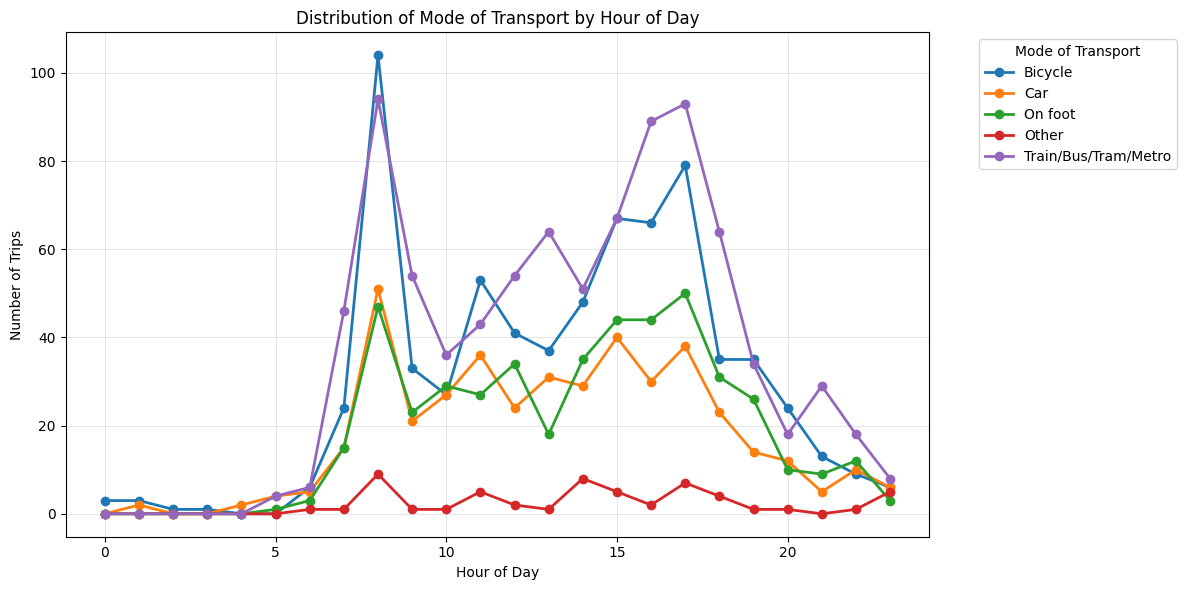

Mode of transport distribution by hour:
mode_of_transport_desc  Bicycle  Car  On foot  Other  Train/Bus/Tram/Metro
hour_of_day                                                               
0                             3    0        0      0                     0
1                             3    2        0      0                     0
2                             1    0        0      0                     0
3                             1    0        0      0                     0
4                             0    2        0      0                     0
5                             0    4        1      0                     4
6                             6    5        3      1                     6
7                            24   15       15      1                    46
8                           104   51       47      9                    94
9                            33   21       23      1                    54
10                           27   27       29      1        

/var/folders/bj/r88z9c613s17r0cbp2t30cmm0000gn/T/ipykernel_7175/3388997664.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_to_plot['hour_of_day'] = pd.to_datetime(


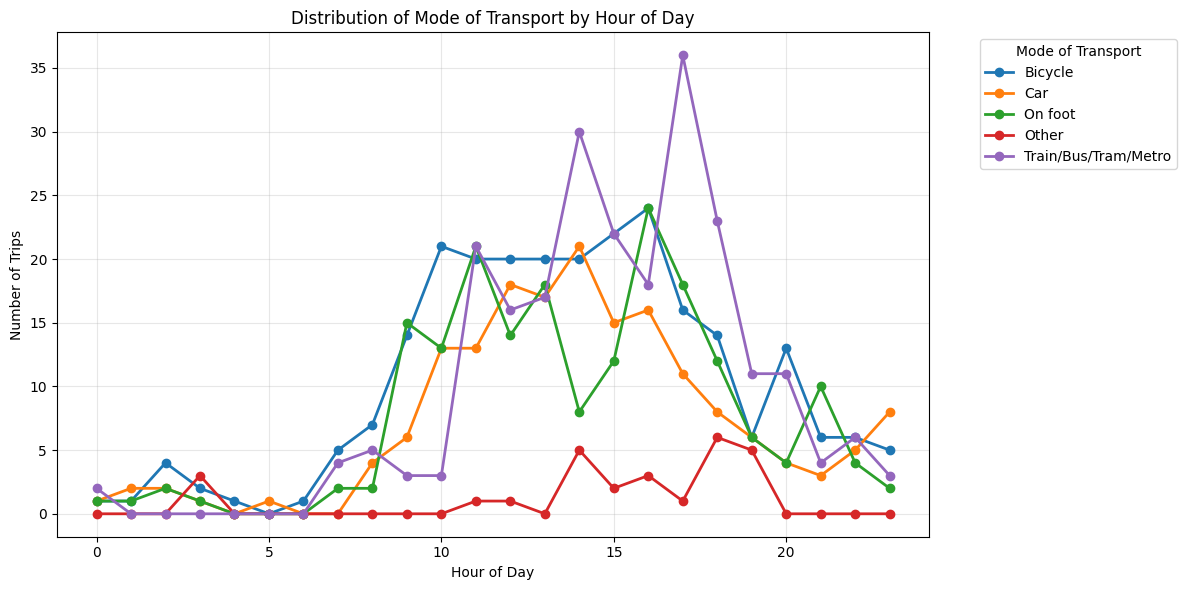

Mode of transport distribution by hour:
mode_of_transport_desc  Bicycle  Car  On foot  Other  Train/Bus/Tram/Metro
hour_of_day                                                               
0                             1    1        1      0                     2
1                             1    2        1      0                     0
2                             4    2        2      0                     0
3                             2    1        1      3                     0
4                             1    0        0      0                     0
5                             0    1        0      0                     0
6                             1    0        0      0                     0
7                             5    0        2      0                     4
8                             7    4        2      0                     5
9                            14    6       15      0                     3
10                           21   13       13      0        

In [15]:
def plot_mode_of_transport_by_hour_line(data_to_plot, y_column):
    # Create hour_of_day column from timestamp_departure
    data_to_plot['hour_of_day'] = pd.to_datetime(
        data_to_plot['timestamp_departure']).dt.hour

    # Plot the distribution of mode_of_transport over hour_of_day
    import matplotlib.pyplot as plt
    import seaborn as sns

    plt.figure(figsize=(12, 6))
    mode_hour_dist = data_to_plot.groupby(
        ['hour_of_day', y_column]).size().unstack(fill_value=0)

    # Create line chart for each travel mode
    for mode in mode_hour_dist.columns:
        plt.plot(mode_hour_dist.index,
                 mode_hour_dist[mode], marker='o', linewidth=2, label=mode)

    plt.title('Distribution of Mode of Transport by Hour of Day')
    plt.xlabel('Hour of Day')
    plt.ylabel('Number of Trips')
    plt.legend(title='Mode of Transport',
               bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Also show a summary table
    print("Mode of transport distribution by hour:")
    print(mode_hour_dist)


for filtered_data in filtered_datasets:
    plot_mode_of_transport_by_hour_line(
        filtered_data, 'mode_of_transport_desc')

In [16]:
import numpy as np

# Temporal patterns (time_factor)
n_temporal_patterns = time_factor.shape[1]
temporal_patterns = [f"P{p}" for p in range(n_temporal_patterns)]

# Origin patterns (origin_factor)
n_origin_patterns = origin_factor.shape[1]
origin_patterns = [f"O{p}" for p in range(n_origin_patterns)]

# Destination patterns (destination_factor)
n_destination_patterns = destination_factor.shape[1]
destination_patterns = [f"D{p}" for p in range(n_destination_patterns)]

# Initialize new columns for all pattern types
for pattern in temporal_patterns:
    filtered_data[f'temporal_pattern_{pattern}'] = 0.0

for pattern in origin_patterns:
    filtered_data[f'origin_pattern_{pattern}'] = 0.0

for pattern in destination_patterns:
    filtered_data[f'destination_pattern_{pattern}'] = 0.0

# Create reverse mappings from postal code to index
origin_pc_to_idx = {pc: idx for idx, pc in idx_to_origins.items()}
destination_pc_to_idx = {pc: idx for idx, pc in idx_to_destinations.items()}

# For each trip, set the intensity of patterns based on hour, origin, and destination
for idx, row in filtered_data.iterrows():
    hour = int(row['hour_of_day'])
    origin_pc = int(row['pc4_departure'])
    destination_pc = int(row['pc4_arrival'])

    # Set temporal patterns based on hour
    if 0 <= hour < time_factor.shape[0]:
        hour_patterns = time_factor[hour]
        for p, pattern in enumerate(temporal_patterns):
            filtered_data.at[idx,
                             f'temporal_pattern_{pattern}'] = hour_patterns[p]

    # Set origin patterns based on postal code using index mapping
    if origin_pc in origin_pc_to_idx:
        origin_idx = origin_pc_to_idx[origin_pc]
        origin_patterns_values = origin_factor[origin_idx]
        for p, pattern in enumerate(origin_patterns):
            filtered_data.at[idx,
                             f'origin_pattern_{pattern}'] = origin_patterns_values[p]

    # Set destination patterns based on postal code using index mapping
    if destination_pc in destination_pc_to_idx:
        destination_idx = destination_pc_to_idx[destination_pc]
        destination_patterns_values = destination_factor[destination_idx]
        for p, pattern in enumerate(destination_patterns):
            filtered_data.at[idx,
                             f'destination_pattern_{pattern}'] = destination_patterns_values[p]

# # Display the first few rows to verify the new columns
# print("New temporal pattern columns added:")
# temporal_cols = [
#     f'temporal_pattern_{pattern}' for pattern in temporal_patterns]
# print(filtered_data[['hour_of_day'] + temporal_cols].head())

# print("\nNew origin pattern columns added:")
# origin_cols = [f'origin_pattern_{pattern}' for pattern in origin_patterns]
# print(filtered_data[['pc4_departure'] + origin_cols].head())

# print("\nNew destination pattern columns added:")
# destination_cols = [
#     f'destination_pattern_{pattern}' for pattern in destination_patterns]
# print(filtered_data[['pc4_arrival'] + destination_cols].head())

# # Show summary statistics of all patterns
# print("\nSummary statistics of temporal patterns:")
# print(filtered_data[temporal_cols].describe())

# print("\nSummary statistics of origin patterns:")
# print(filtered_data[origin_cols].describe())

# print("\nSummary statistics of destination patterns:")
# print(filtered_data[destination_cols].describe())

/var/folders/bj/r88z9c613s17r0cbp2t30cmm0000gn/T/ipykernel_7175/1109622243.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data[f'temporal_pattern_{pattern}'] = 0.0
/var/folders/bj/r88z9c613s17r0cbp2t30cmm0000gn/T/ipykernel_7175/1109622243.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data[f'temporal_pattern_{pattern}'] = 0.0
/var/folders/bj/r88z9c613s17r0cbp2t30cmm0000gn/T/ipykernel_7175/1109622243.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

In [17]:
# # Get the temporal pattern columns
# temporal_cols = [
#     col for col in filtered_data.columns if col.startswith('temporal_pattern_')]

# # Use argmax to find the pattern with highest value for each row
# assigned_patterns = filtered_data[temporal_cols].idxmax(axis=1)

# # Extract just the pattern name (remove 'temporal_pattern_' prefix)
# filtered_data['assigned_pattern'] = assigned_patterns.str.replace(
#     'temporal_pattern_', '')

# # Display the result
# print("Assigned patterns for each trip:")
# print(
#     filtered_data[['hour_of_day', 'assigned_pattern'] + temporal_cols].head())

# # Show distribution of assigned patterns
# print("\nDistribution of assigned patterns:")
# print(filtered_data['assigned_pattern'].value_counts())

In [18]:
# # Plot mode of transport distribution for each temporal pattern
# unique_patterns = filtered_data['assigned_pattern'].unique()

# for pattern in unique_patterns:
#     # Filter data for current pattern
#     pattern_data = filtered_data[filtered_data['assigned_pattern'] == pattern].copy(
#     )

#     # Add hour_of_day column if not present
#     pattern_data['hour_of_day'] = pd.to_datetime(
#         pattern_data['timestamp_departure']).dt.hour

#     print(f"\n=== Pattern {pattern} ===")
#     print(f"Number of trips: {len(pattern_data)}")

#     # Plot mode of transport distribution for this pattern
#     plot_mode_of_transport_by_hour_bar(pattern_data, "mode_of_transport_desc")

In [19]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt

# # Re-create or reload your filtered_data here...
# # filtered_data = pd.read_csv(...)


# # Identify the temporal pattern columns
# temporal_cols = [
#     c for c in filtered_data.columns if c.startswith("temporal_pattern_P")]

# # 1) Weighted counts per pattern & travel mode
# pattern_mode_counts = {
#     pat: filtered_data.groupby('mode_of_transport_desc')[pat].sum().to_dict()
#     for pat in temporal_cols
# }

# # 2) Pattern‐level mode shares
# pattern_totals = {pat: sum(cnts.values())
#                   for pat, cnts in pattern_mode_counts.items()}
# pattern_mode_shares = {
#     pat: {mode: cnt / pattern_totals[pat] for mode, cnt in cnts.items()}
#     for pat, cnts in pattern_mode_counts.items()
# }

# # 3) Baseline mode share
# baseline = filtered_data['mode_of_transport_desc'].value_counts(
#     normalize=True).to_dict()

# # 4) Compute Δ = S_{r,m} − B_m
# all_modes = sorted(set(baseline) | set().union(
#     *[cnts.keys() for cnts in pattern_mode_counts.values()]))
# delta = {
#     pat: {mode: pattern_mode_shares[pat].get(
#         mode, 0) - baseline.get(mode, 0) for mode in all_modes}
#     for pat in temporal_cols
# }

# # 5) Build a DataFrame
# delta_df = pd.DataFrame(delta).T.fillna(0)
# delta_df.index = [i.replace("temporal_pattern_", "") for i in delta_df.index]

# print("Δ Travel Mode Share per Pattern vs Baseline:")
# display(delta_df)

# # 6) Plot grouped bar chart
# fig, ax = plt.subplots(figsize=(10, 6))
# delta_df.plot(kind='bar', ax=ax)
# ax.axhline(0, color='black', linewidth=0.8)
# ax.set_xlabel('Pattern')
# ax.set_ylabel('Δ Mode Share')
# ax.set_title('Δ Travel Mode Share per Temporal Pattern')
# ax.legend(title='Travel Mode', bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.tight_layout()
# plt.show()

# Travel Mode Analysis by pattern


/var/folders/bj/r88z9c613s17r0cbp2t30cmm0000gn/T/ipykernel_7175/2040610222.py:178: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


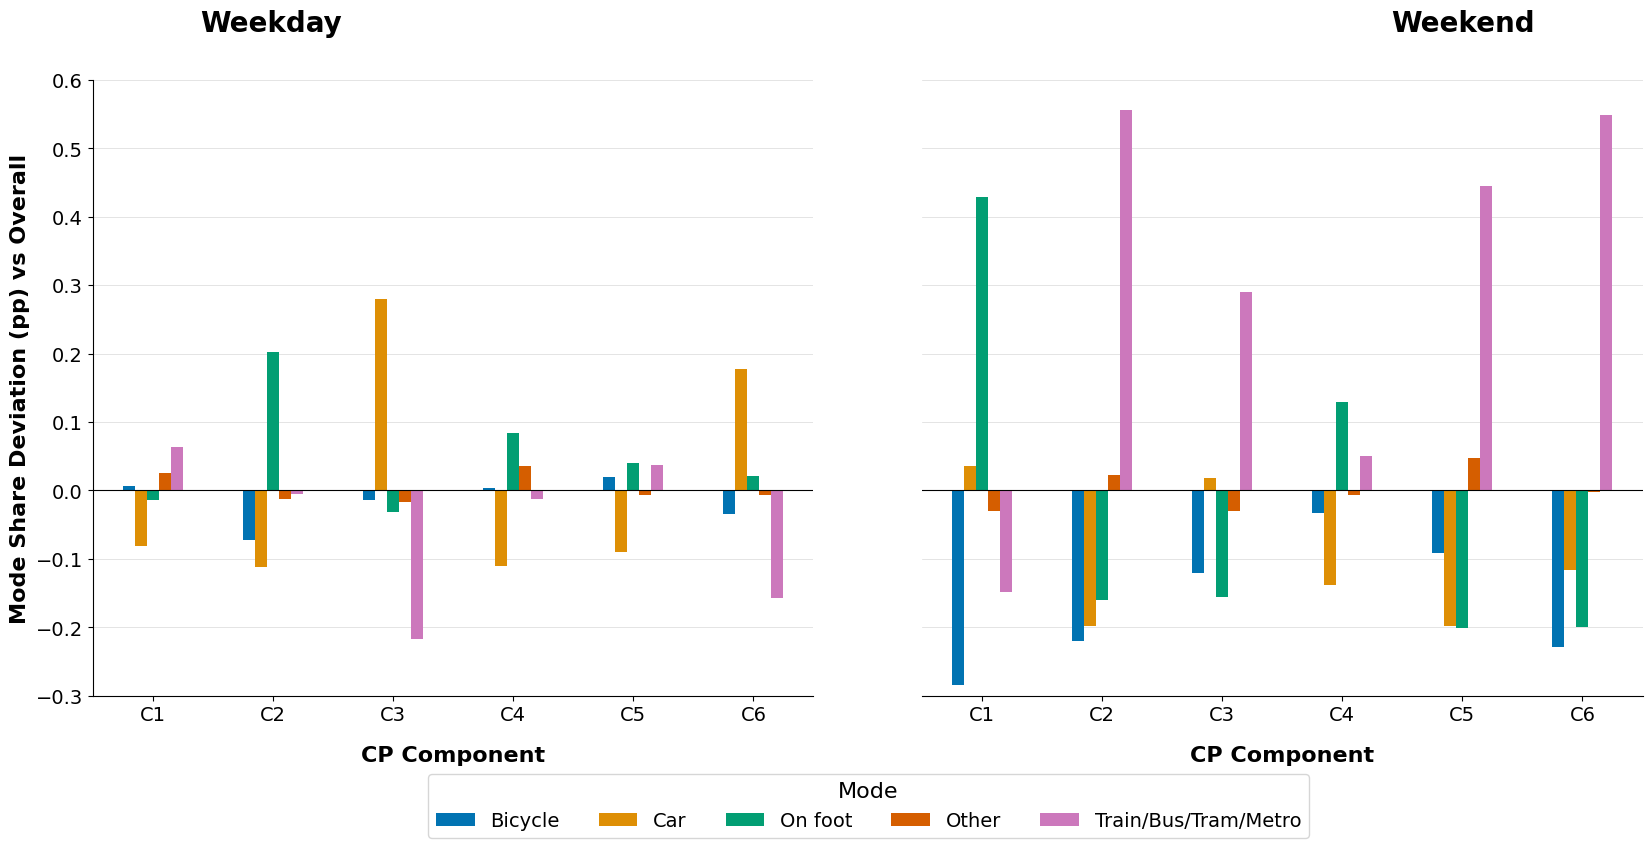

In [20]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

delta_dfs = []
mode_shares_patterns = []

# Set larger font sizes for all text elements
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 10,
    'figure.titlesize': 18
})

# Create figure with two subplots side by side with increased spacing
fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize=(20, 8), gridspec_kw={'wspace': 0.15})

# Process both weekday and weekend decompositions
for idx, (decomposition_path, title, ax) in enumerate([
    (decomposition_path_weekday, "Weekday", ax1),
    (decomposition_path_weekend, "Weekend", ax2)
]):
    origin_factor, destination_factor, time_factor, idx_to_origins, idx_to_destinations = get_decomposition_data(
        decomposition_path, title)

    # 1) Build reverse lookup dicts
    origin_pc4_to_idx = {pc4: idx for idx, pc4 in idx_to_origins.items()}
    destination_pc4_to_idx = {pc4: idx for idx,
                              pc4 in idx_to_destinations.items()}

    filtered_data = None
    if "day" in title:
        filtered_data = filtered_datasets[0]
    elif "end" in title:
        filtered_data = filtered_datasets[1]
    # 2) Map postal codes to integer indices & drop any trips without a mapping
    filtered = (
        filtered_data
        .assign(
            orig_idx=lambda df: df["pc4_departure"].map(
                origin_pc4_to_idx).astype("Int64"),
            dest_idx=lambda df: df["pc4_arrival"].map(
                destination_pc4_to_idx).astype("Int64"),
            hour=lambda df: df["hour_of_day"].astype(int)
        )
        .dropna(subset=["orig_idx", "dest_idx"])  # removes trips with no match
        .assign(
            orig_idx=lambda df: df["orig_idx"].astype(int),
            dest_idx=lambda df: df["dest_idx"].astype(int)
        )
    )

    # 3) Extract indices as numpy arrays
    hours = filtered["hour"].to_numpy(dtype=int)
    orig_idx = filtered["orig_idx"].to_numpy(dtype=int)
    dest_idx = filtered["dest_idx"].to_numpy(dtype=int)

    # 4) Vectorized lookup of all R components for each trip
    R = origin_factor.shape[1]
    time_vals = time_factor[hours, :]          # (n_trips, R)
    origin_vals = origin_factor[orig_idx, :]     # (n_trips, R)
    destination_vals = destination_factor[dest_idx, :]  # (n_trips, R)

    # 5) Element‐wise multiply to get the CP weights matrix
    cp_weights = time_vals * origin_vals * destination_vals  # (n_trips, R)

    # 6) Attach to DataFrame
    cp_df = pd.DataFrame(
        cp_weights,
        # Use k+1 for C1, C2, etc.
        columns=[f"cp_weight_{k+1}" for k in range(R)],
        index=filtered.index
    )
    filtered = pd.concat([filtered, cp_df], axis=1)

    # 7) Aggregate: sum weights by mode for each component
    composite_cols = cp_df.columns.tolist()
    pattern_mode_counts = {
        comp: filtered.groupby("mode_of_transport_desc")[comp].sum()
        for comp in composite_cols
    }

    # 8) Compute shares
    pattern_mode_shares = {
        comp: (vals / vals.sum()).to_dict()
        for comp, vals in pattern_mode_counts.items()
    }
    mode_shares_patterns.append(pattern_mode_shares)

    # 9) Baseline (unweighted) mode‐share
    baseline = filtered["mode_of_transport_desc"] \
        .value_counts(normalize=True) \
        .to_dict()

    # 10) Δ = component share – baseline
    all_modes = sorted(set(baseline) | set.union(
        *[set(d.keys()) for d in pattern_mode_shares.values()]))
    delta = {
        comp: {
            m: pattern_mode_shares[comp].get(m, 0.) - baseline.get(m, 0.)
            for m in all_modes
        }
        for comp in composite_cols
    }

    # 11) Build DataFrame & plot
    delta_df = (
        pd.DataFrame(delta)
          .T
          .rename(index=lambda s: s.replace("cp_weight_", "C"))
    )

    delta_dfs.append(delta_df)

    # Plot on the appropriate subplot
    delta_df.plot(kind="bar", ax=ax, color=[mode_colors.get(
        mode, '#000000') for mode in delta_df.columns])

    ax.axhline(0, color="k", lw=0.8)
    ax.set_xlabel("CP Component", fontsize=16, weight='bold', labelpad=15)
    ax.set_ylabel("Mode Share Deviation (pp) vs Overall",
                  fontsize=16, weight='bold')

    # Position titles differently for left and right plots with adjusted padding
    if idx == 0:  # Left plot (Weekday)
        ax.set_title(title, fontsize=20, weight='bold',
                     pad=35, loc='left', x=0.15)
    else:  # Right plot (Weekend)
        ax.set_title(title, fontsize=20, weight='bold',
                     pad=35, loc='right', x=0.85)

    # Make x-axis labels upright
    ax.tick_params(axis='x', rotation=0, labelsize=14)
    ax.tick_params(axis='y', labelsize=14)

    # Remove top and right borders
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Add light grey horizontal grid lines
    ax.yaxis.grid(True, alpha=0.3, color='grey', linestyle='-', linewidth=0.5)
    ax.set_axisbelow(True)

    # Set y-axis limits to be consistent
    if "utrecht" in decomposition_path:
        ax.set_ylim(-0.3, 0.6)
    elif "rotterdam" in decomposition_path:
        ax.set_ylim(-0.3, 0.6)

    # Remove left border/y-axis for the right chart
    if idx == 1:  # Weekend chart (right side)
        ax.spines['left'].set_visible(False)
        # hide ticks & labels but preserve tick positions
        ax.tick_params(
            axis='y', which='both',
            left=False,      # no tick‐marks
            labelleft=False  # no tick‐labels
        )
        ax.set_ylabel("")


# Add single legend below the charts with larger font
handles, labels = ax2.get_legend_handles_labels()
fig.legend(handles, labels, title="Mode", loc='lower center', bbox_to_anchor=(0.513, -0.08),
           ncol=len(labels), fontsize=14, title_fontsize=16)

# Remove individual legends from subplots
if ax1.get_legend() is not None:
    ax1.get_legend().remove()
if ax2.get_legend() is not None:
    ax2.get_legend().remove()

plt.tight_layout()
plt.show()


city = "utrecht" if "utrecht" in decomposition_path_weekday else "rotterdam"
save_plot(fig, "mode", city)

In [21]:
mode_shares_patterns[0]

{'cp_weight_1': {'Bicycle': 0.2885967791080475,
  'Car': 0.08719637989997864,
  'On foot': 0.16828475892543793,
  'Other': 0.04693891853094101,
  'Train/Bus/Tram/Metro': 0.40898314118385315},
 'cp_weight_2': {'Bicycle': 0.21040698885917664,
  'Car': 0.05673357844352722,
  'On foot': 0.3841143250465393,
  'Other': 0.00893279630690813,
  'Train/Bus/Tram/Metro': 0.3398122787475586},
 'cp_weight_3': {'Bicycle': 0.2690008878707886,
  'Car': 0.4470420181751251,
  'On foot': 0.15011601150035858,
  'Other': 0.0053741903975605965,
  'Train/Bus/Tram/Metro': 0.1284668743610382},
 'cp_weight_4': {'Bicycle': 0.2861800789833069,
  'Car': 0.05723633989691734,
  'On foot': 0.2664394676685333,
  'Other': 0.05796492472290993,
  'Train/Bus/Tram/Metro': 0.3321792185306549},
 'cp_weight_5': {'Bicycle': 0.3030455708503723,
  'Car': 0.0784764215350151,
  'On foot': 0.22164717316627502,
  'Other': 0.01480114832520485,
  'Train/Bus/Tram/Metro': 0.3820297122001648},
 'cp_weight_6': {'Bicycle': 0.248734727501869

In [22]:
mode_shares_patterns[1]

{'cp_weight_1': {'Bicycle': 0.00025811040541157126,
  'Car': 0.2348204255104065,
  'On foot': 0.6452645063400269,
  'Other': 1.912878178700339e-05,
  'Train/Bus/Tram/Metro': 0.11963777244091034},
 'cp_weight_2': {'Bicycle': 0.06375665217638016,
  'Car': 0.0018934108084067702,
  'On foot': 0.0571187399327755,
  'Other': 0.05306440219283104,
  'Train/Bus/Tram/Metro': 0.8241667747497559},
 'cp_weight_3': {'Bicycle': 0.16358758509159088,
  'Car': 0.21758253872394562,
  'On foot': 0.060425516217947006,
  'Other': 0.0004903045482933521,
  'Train/Bus/Tram/Metro': 0.5579140782356262},
 'cp_weight_4': {'Bicycle': 0.25067299604415894,
  'Car': 0.06118667125701904,
  'On foot': 0.3455071747303009,
  'Other': 0.02480936236679554,
  'Train/Bus/Tram/Metro': 0.31782376766204834},
 'cp_weight_5': {'Bicycle': 0.19302527606487274,
  'Car': 0.0010523370001465082,
  'On foot': 0.01515559758991003,
  'Other': 0.07808083295822144,
  'Train/Bus/Tram/Metro': 0.7126860022544861},
 'cp_weight_6': {'Bicycle': 0.

In [23]:
# WEEKDAY
delta_dfs[0]

,Bicycle,Car,On foot,Other,Train/Bus/Tram/Metro
C1,0.005765,-0.080921,-0.014073,0.025183,0.064046
C2,-0.072425,-0.111384,0.201757,-0.012824,-0.005124
C3,-0.013831,0.278925,-0.032242,-0.016382,-0.216470
C4,0.003348,-0.110881,0.084082,0.036209,-0.012757
C5,0.020213,-0.089641,0.039290,-0.006955,0.037093
C6,-0.034098,0.177732,0.021132,-0.006851,-0.157916


In [24]:
# WEEKEND
delta_dfs[1]

,Bicycle,Car,On foot,Other,Train/Bus/Tram/Metro
C1,-0.283988,0.035049,0.428370,-0.030803,-0.148627
C2,-0.220490,-0.197878,-0.159776,0.022242,0.555902
C3,-0.120659,0.017811,-0.156469,-0.030332,0.289649
C4,-0.033574,-0.138585,0.128612,-0.006013,0.049559
C5,-0.091221,-0.198719,-0.201739,0.047259,0.444421
C6,-0.229124,-0.116361,-0.200113,-0.002388,0.547987


# Purpose analysis


/var/folders/bj/r88z9c613s17r0cbp2t30cmm0000gn/T/ipykernel_7175/3707498526.py:176: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


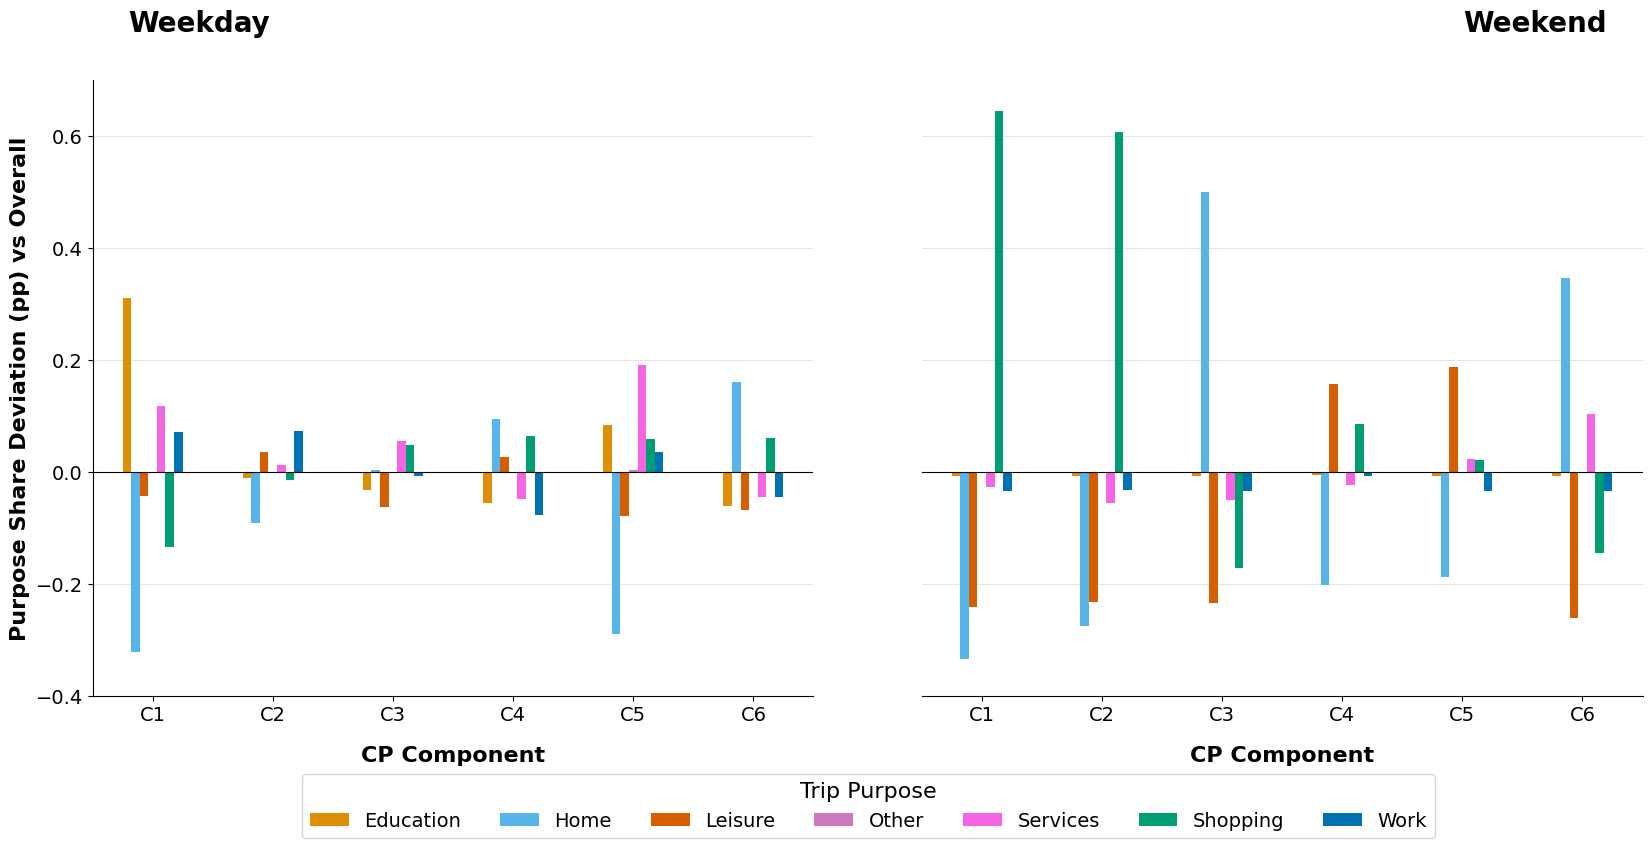

In [25]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

delta_dfs = []
purpose_shares_patterns = []

# Set larger font sizes for all text elements
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 10,
    'figure.titlesize': 18
})

# Create figure with two subplots side by side with increased spacing
fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize=(20, 8), gridspec_kw={'wspace': 0.15})

# Process both weekday and weekend decompositions
for idx, (decomposition_path, title, ax) in enumerate([
    (decomposition_path_weekday, "Weekday", ax1),
    (decomposition_path_weekend, "Weekend", ax2)
]):
    origin_factor, destination_factor, time_factor, idx_to_origins, idx_to_destinations = get_decomposition_data(
        decomposition_path, title)

    # 1) Build reverse lookup dicts
    origin_pc4_to_idx = {pc4: idx for idx, pc4 in idx_to_origins.items()}
    destination_pc4_to_idx = {pc4: idx for idx,
                              pc4 in idx_to_destinations.items()}

    filtered_data = None
    if "day" in title:
        filtered_data = filtered_datasets[0]
    elif "end" in title:
        filtered_data = filtered_datasets[1]

    # 2) Map postal codes to integer indices & drop any trips without a mapping
    filtered = (
        filtered_data
        .assign(
            orig_idx=lambda df: df["pc4_departure"].map(
                origin_pc4_to_idx).astype("Int64"),
            dest_idx=lambda df: df["pc4_arrival"].map(
                destination_pc4_to_idx).astype("Int64"),
            hour=lambda df: df["hour_of_day"].astype(int)
        )
        .dropna(subset=["orig_idx", "dest_idx"])  # removes trips with no match
        .assign(
            orig_idx=lambda df: df["orig_idx"].astype(int),
            dest_idx=lambda df: df["dest_idx"].astype(int)
        )
    )

    # 3) Extract indices as numpy arrays
    hours = filtered["hour"].to_numpy(dtype=int)
    orig_idx = filtered["orig_idx"].to_numpy(dtype=int)
    dest_idx = filtered["dest_idx"].to_numpy(dtype=int)

    # 4) Vectorized lookup of all R components for each trip
    R = origin_factor.shape[1]
    time_vals = time_factor[hours, :]          # (n_trips, R)
    origin_vals = origin_factor[orig_idx, :]     # (n_trips, R)
    destination_vals = destination_factor[dest_idx, :]  # (n_trips, R)

    # 5) Element‐wise multiply to get the CP weights matrix
    cp_weights = time_vals * origin_vals * destination_vals  # (n_trips, R)

    # 6) Attach to DataFrame
    cp_df = pd.DataFrame(
        cp_weights,
        # Use k+1 for C1, C2, etc.
        columns=[f"cp_weight_{k+1}" for k in range(R)],
        index=filtered.index
    )
    filtered = pd.concat([filtered, cp_df], axis=1)

    # 7) Aggregate: sum weights by mode for each component
    composite_cols = cp_df.columns.tolist()
    pattern_mode_counts = {
        comp: filtered.groupby("trip_purpose_desc")[comp].sum()
        for comp in composite_cols
    }

    # 8) Compute shares
    pattern_mode_shares = {
        comp: (vals / vals.sum()).to_dict()
        for comp, vals in pattern_mode_counts.items()
    }
    purpose_shares_patterns.append(pattern_mode_shares)

    # 9) Baseline (unweighted) mode‐share
    baseline = filtered["trip_purpose_desc"] \
        .value_counts(normalize=True) \
        .to_dict()

    # 10) Δ = component share – baseline
    all_modes = sorted(set(baseline) | set.union(
        *[set(d.keys()) for d in pattern_mode_shares.values()]))
    delta = {
        comp: {
            m: pattern_mode_shares[comp].get(m, 0.) - baseline.get(m, 0.)
            for m in all_modes
        }
        for comp in composite_cols
    }

    # 11) Build DataFrame & plot
    delta_df = (
        pd.DataFrame(delta)
          .T
          .rename(index=lambda s: s.replace("cp_weight_", "C"))
    )

    delta_dfs.append(delta_df)
    # Plot on the appropriate subplot
    delta_df.plot(kind="bar", ax=ax, color=[purpose_colors.get(
        mode, '#000000') for mode in delta_df.columns])

    ax.axhline(0, color="k", lw=0.8)
    ax.set_xlabel("CP Component", fontsize=16, weight='bold', labelpad=15)
    ax.set_ylabel("Purpose Share Deviation (pp) vs Overall",
                  fontsize=16, weight='bold')

    # Position titles differently for left and right plots with adjusted padding
    if idx == 0:  # Left plot (Weekday)
        ax.set_title(title, fontsize=20, weight='bold',
                     pad=35, loc='left', x=0.05)
    else:  # Right plot (Weekend)
        ax.set_title(title, fontsize=20, weight='bold',
                     pad=35, loc='right', x=0.95)

    # Make x-axis labels upright
    ax.tick_params(axis='x', rotation=0, labelsize=14)
    ax.tick_params(axis='y', labelsize=14)

    # Remove top and right borders
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Add light grey horizontal grid lines
    ax.yaxis.grid(True, alpha=0.3, color='grey', linestyle='-', linewidth=0.5)
    ax.set_axisbelow(True)

    # Set y-axis limits to be consistent
    if "utrecht" in decomposition_path:
        ax.set_ylim(-0.4, 0.7)
    elif "rotterdam" in decomposition_path:
        ax.set_ylim(-0.4, 0.7)

    # Remove left border/y-axis for the right chart
    if idx == 1:  # Weekend chart (right side)
        ax.spines['left'].set_visible(False)
        # hide ticks & labels but preserve tick positions
        ax.tick_params(
            axis='y', which='both',
            left=False,      # no tick‐marks
            labelleft=False  # no tick‐labels
        )
        ax.set_ylabel("")


# Add single legend at the top with larger font
handles, labels = ax2.get_legend_handles_labels()
fig.legend(handles, labels, title="Trip Purpose", loc='lower center', bbox_to_anchor=(0.513, -0.08),
           ncol=len(labels), fontsize=14, title_fontsize=16)

# Remove individual legends from subplots
ax1.get_legend().remove()
ax2.get_legend().remove()

plt.tight_layout()
plt.show()

save_plot(fig, "purpose", city)


# # Print verification for both decompositions
# for decomposition_path in [decomposition_path_weekday, decomposition_path_weekend]:
#     origin_factor, destination_factor, time_factor, idx_to_origins, idx_to_destinations = get_decomposition_data(
#         decomposition_path)

#     # ... (same processing logic as above) ...
#     # For brevity, just showing the verification part:
#     print(f"Verification for {decomposition_path}:")
#     # (Include the same processing steps as above to get delta)
#     # Then print:
#     # for comp, deltas in delta.items():
#     #     print(comp, round(sum(deltas.values()), 6))

In [26]:
purpose_shares_patterns[0]

{'cp_weight_1': {'Education': 0.3938390016555786,
  'Home': 0.10709027945995331,
  'Leisure': 0.09357760101556778,
  'Other': 1.372000468791157e-07,
  'Services': 0.21105527877807617,
  'Shopping': 0.00578316068276763,
  'Work': 0.18865449726581573},
 'cp_weight_2': {'Education': 0.07257628440856934,
  'Home': 0.33625584840774536,
  'Leisure': 0.1713452935218811,
  'Other': 9.779230458661914e-05,
  'Services': 0.10430310666561127,
  'Shopping': 0.12503111362457275,
  'Work': 0.19039058685302734},
 'cp_weight_3': {'Education': 0.05051564797759056,
  'Home': 0.43072736263275146,
  'Leisure': 0.07394830882549286,
  'Other': 3.1377454823622006e-39,
  'Services': 0.14718188345432281,
  'Shopping': 0.18755093216896057,
  'Work': 0.11007589101791382},
 'cp_weight_4': {'Education': 0.02731187641620636,
  'Home': 0.5220614075660706,
  'Leisure': 0.1618272364139557,
  'Other': 0.0011197051499038935,
  'Services': 0.044778261333703995,
  'Shopping': 0.20274639129638672,
  'Work': 0.04015510901808

In [27]:
# WEEKDAY
delta_dfs[0]

,Education,Home,Leisure,Other,Services,Shopping,Work
C1,0.310769,-0.321312,-0.042498,-0.001582,0.118096,-0.133853,0.070379
C2,-0.010493,-0.092146,0.035269,-0.001484,0.011344,-0.014605,0.072115
C3,-0.032554,0.002325,-0.062128,-0.001582,0.054223,0.047915,-0.008199
C4,-0.055758,0.093660,0.025751,-0.000463,-0.048181,0.063110,-0.078120
C5,0.083155,-0.289989,-0.078385,0.002187,0.190494,0.057787,0.034751
C6,-0.060521,0.160429,-0.068896,-0.001567,-0.044989,0.060970,-0.045426


In [28]:
# WEEKEND
delta_dfs[1]

,Education,Home,Leisure,Other,Services,Shopping,Work
C1,-0.006823,-0.333554,-0.241484,-0.002283,-0.026436,0.644707,-0.034126
C2,-0.006849,-0.275954,-0.232220,-0.002283,-0.055406,0.606177,-0.033464
C3,-0.006847,0.499080,-0.233551,-0.002283,-0.050081,-0.172074,-0.034244
C4,-0.005857,-0.202711,0.155887,-0.002023,-0.024179,0.086075,-0.007192
C5,-0.006816,-0.188326,0.187689,-0.002283,0.022519,0.021462,-0.034245
C6,-0.006849,0.345560,-0.261370,-0.002283,0.103711,-0.144523,-0.034246


### manual


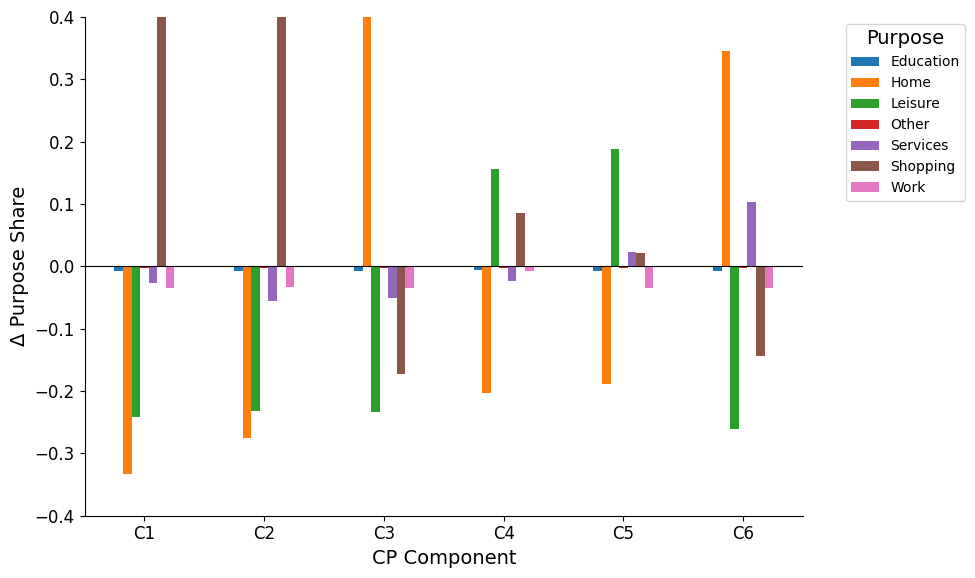

C1 0.0
C2 -0.0
C3 -0.0
C4 0.0
C5 -0.0
C6 0.0


In [29]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- assume these are already defined:
# filtered_data           : your pandas DataFrame
# time_factor             : numpy array, shape (n_hours, R)
# origin_factor           : numpy array, shape (n_origins, R)
# destination_factor      : numpy array, shape (n_dests,   R)
# idx_to_origins          : dict mapping origin_idx → postal_code
# idx_to_destinations     : dict mapping dest_idx   → postal_code

# 1) Build reverse lookup dicts
origin_pc4_to_idx = {pc4: idx for idx, pc4 in idx_to_origins.items()}
destination_pc4_to_idx = {pc4: idx for idx, pc4 in idx_to_destinations.items()}

# 2) Map postal codes to integer indices & drop any trips without a mapping
filtered = (
    filtered_data
    .assign(
        orig_idx=lambda df: df["pc4_departure"].map(
            origin_pc4_to_idx).astype("Int64"),
        dest_idx=lambda df: df["pc4_arrival"].map(
            destination_pc4_to_idx).astype("Int64"),
        hour=lambda df: df["hour_of_day"].astype(int)
    )
    .dropna(subset=["orig_idx", "dest_idx"])  # removes trips with no match
    .assign(
        orig_idx=lambda df: df["orig_idx"].astype(int),
        dest_idx=lambda df: df["dest_idx"].astype(int)
    )
)

# 3) Extract indices as numpy arrays
hours = filtered["hour"].to_numpy(dtype=int)
orig_idx = filtered["orig_idx"].to_numpy(dtype=int)
dest_idx = filtered["dest_idx"].to_numpy(dtype=int)

# 4) Vectorized lookup of all R components for each trip
R = origin_factor.shape[1]
time_vals = time_factor[hours, :]          # (n_trips, R)
origin_vals = origin_factor[orig_idx, :]     # (n_trips, R)
destination_vals = destination_factor[dest_idx, :]  # (n_trips, R)

# 5) Element‐wise multiply to get the CP weights matrix
cp_weights = time_vals * origin_vals * destination_vals  # (n_trips, R)

# 6) Attach to DataFrame
cp_df = pd.DataFrame(
    cp_weights,
    columns=[f"cp_weight_{k+1}" for k in range(R)],  # Use k+1 for C1, C2, etc.
    index=filtered.index
)
filtered = pd.concat([filtered, cp_df], axis=1)

# 7) Aggregate: sum weights by purpose for each component
composite_cols = cp_df.columns.tolist()
pattern_purpose_counts = {
    comp: filtered.groupby("trip_purpose_desc")[comp].sum()
    for comp in composite_cols
}

# 8) Compute shares
pattern_purpose_shares = {
    comp: (vals / vals.sum()).to_dict()
    for comp, vals in pattern_purpose_counts.items()
}

# 9) Baseline (unweighted) purpose‐share
baseline = filtered["trip_purpose_desc"] \
    .value_counts(normalize=True) \
    .to_dict()

# 10) Δ = component share – baseline
all_purposes = sorted(set(baseline) | set.union(
    *[set(d.keys()) for d in pattern_purpose_shares.values()]))
delta = {
    comp: {
        p: pattern_purpose_shares[comp].get(p, 0.) - baseline.get(p, 0.)
        for p in all_purposes
    }
    for comp in composite_cols
}

# 11) Build DataFrame & plot

# --- replace this: ---
# delta_df = (
#     pd.DataFrame(delta)
#       .T
#       .rename(index=lambda s: s.replace("cp_weight_", "C"))
# )

# --- with this: ---
# 1) Create a DataFrame from your dict of dicts, with CP components as the index
delta_df = pd.DataFrame.from_dict(delta, orient='index')

# 2) Rename the index to C1, C2, … instead of cp_weight_C1, …
delta_df.index = delta_df.index.str.replace("cp_weight_", "C")

# 3) (Optional) sort by component if needed
delta_df = delta_df.sort_index()

# 4) Now plot
fig, ax = plt.subplots(figsize=(10, 6))
delta_df.plot(kind="bar", ax=ax)
ax.legend(title="Purpose", bbox_to_anchor=(1.05, 1), loc="upper left")

ax.axhline(0, color="k", lw=0.8)
ax.set_xlabel("CP Component")
ax.set_ylabel("Δ Purpose Share")
ax.tick_params(axis='x', rotation=0, labelsize=12)
ax.tick_params(axis='y', labelsize=12)

# Set fixed y‐axis scale
ax.set_ylim(-0.4, 0.4)

# Tidy up the spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

# verify sums still zero
for comp, deltas in delta.items():
    print(comp.replace("cp_weight_", "C"), round(sum(deltas.values()), 6))

# age analysis


/var/folders/bj/r88z9c613s17r0cbp2t30cmm0000gn/T/ipykernel_7175/3489376994.py:176: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


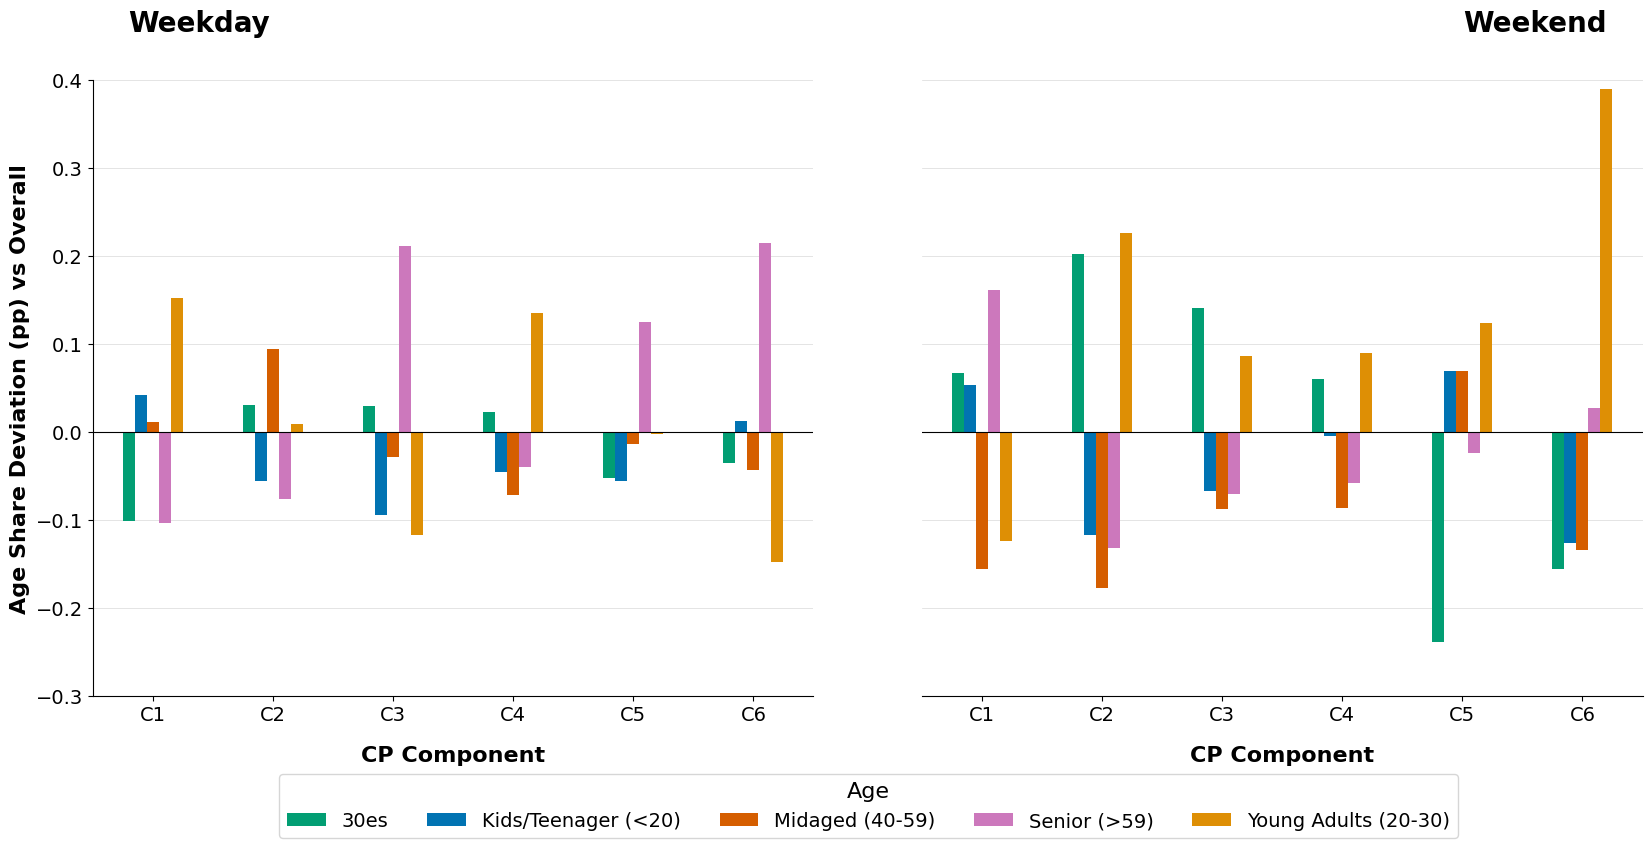

In [30]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

delta_dfs = []
age_shares_patterns = []

# Set larger font sizes for all text elements
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 10,
    'figure.titlesize': 18
})

# Create figure with two subplots side by side with increased spacing
fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize=(20, 8), gridspec_kw={'wspace': 0.15})

# Process both weekday and weekend decompositions
for idx, (decomposition_path, title, ax) in enumerate([
    (decomposition_path_weekday, "Weekday", ax1),
    (decomposition_path_weekend, "Weekend", ax2)
]):
    origin_factor, destination_factor, time_factor, idx_to_origins, idx_to_destinations = get_decomposition_data(
        decomposition_path, title)

    # 1) Build reverse lookup dicts
    origin_pc4_to_idx = {pc4: idx for idx, pc4 in idx_to_origins.items()}
    destination_pc4_to_idx = {pc4: idx for idx,
                              pc4 in idx_to_destinations.items()}

    filtered_data = None
    if "day" in title:
        filtered_data = filtered_datasets[0]
    elif "end" in title:
        filtered_data = filtered_datasets[1]

    # 2) Map postal codes to integer indices & drop any trips without a mapping
    filtered = (
        filtered_data
        .assign(
            orig_idx=lambda df: df["pc4_departure"].map(
                origin_pc4_to_idx).astype("Int64"),
            dest_idx=lambda df: df["pc4_arrival"].map(
                destination_pc4_to_idx).astype("Int64"),
            hour=lambda df: df["hour_of_day"].astype(int)
        )
        .dropna(subset=["orig_idx", "dest_idx"])  # removes trips with no match
        .assign(
            orig_idx=lambda df: df["orig_idx"].astype(int),
            dest_idx=lambda df: df["dest_idx"].astype(int)
        )
    )

    # 3) Extract indices as numpy arrays
    hours = filtered["hour"].to_numpy(dtype=int)
    orig_idx = filtered["orig_idx"].to_numpy(dtype=int)
    dest_idx = filtered["dest_idx"].to_numpy(dtype=int)

    # 4) Vectorized lookup of all R components for each trip
    R = origin_factor.shape[1]
    time_vals = time_factor[hours, :]          # (n_trips, R)
    origin_vals = origin_factor[orig_idx, :]     # (n_trips, R)
    destination_vals = destination_factor[dest_idx, :]  # (n_trips, R)

    # 5) Element‐wise multiply to get the CP weights matrix
    cp_weights = time_vals * origin_vals * destination_vals  # (n_trips, R)

    # 6) Attach to DataFrame
    cp_df = pd.DataFrame(
        cp_weights,
        # Use k+1 for C1, C2, etc.
        columns=[f"cp_weight_{k+1}" for k in range(R)],
        index=filtered.index
    )
    filtered = pd.concat([filtered, cp_df], axis=1)

    # 7) Aggregate: sum weights by mode for each component
    composite_cols = cp_df.columns.tolist()
    pattern_mode_counts = {
        comp: filtered.groupby("age_desc")[comp].sum()
        for comp in composite_cols
    }

    # 8) Compute shares
    pattern_mode_shares = {
        comp: (vals / vals.sum()).to_dict()
        for comp, vals in pattern_mode_counts.items()
    }
    age_shares_patterns.append(pattern_mode_shares)

    # 9) Baseline (unweighted) mode‐share
    baseline = filtered["age_desc"] \
        .value_counts(normalize=True) \
        .to_dict()

    # 10) Δ = component share – baseline
    all_modes = sorted(set(baseline) | set.union(
        *[set(d.keys()) for d in pattern_mode_shares.values()]))
    delta = {
        comp: {
            m: pattern_mode_shares[comp].get(m, 0.) - baseline.get(m, 0.)
            for m in all_modes
        }
        for comp in composite_cols
    }

    # 11) Build DataFrame & plot
    delta_df = (
        pd.DataFrame(delta)
          .T
          .rename(index=lambda s: s.replace("cp_weight_", "C"))
    )

    delta_dfs.append(delta_df)
    # Plot on the appropriate subplot
    delta_df.plot(kind="bar", ax=ax, color=[age_colors.get(
        mode, '#000000') for mode in delta_df.columns])

    ax.axhline(0, color="k", lw=0.8)
    ax.set_xlabel("CP Component", fontsize=16, weight='bold', labelpad=15)
    ax.set_ylabel("Age Share Deviation (pp) vs Overall",
                  fontsize=16, weight='bold')

    # Position titles differently for left and right plots with adjusted padding
    if idx == 0:  # Left plot (Weekday)
        ax.set_title(title, fontsize=20, weight='bold',
                     pad=35, loc='left', x=0.05)
    else:  # Right plot (Weekend)
        ax.set_title(title, fontsize=20, weight='bold',
                     pad=35, loc='right', x=0.95)

    # Make x-axis labels upright
    ax.tick_params(axis='x', rotation=0, labelsize=14)
    ax.tick_params(axis='y', labelsize=14)

    # Remove top and right borders
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Add light grey horizontal grid lines
    ax.yaxis.grid(True, alpha=0.3, color='grey', linestyle='-', linewidth=0.5)
    ax.set_axisbelow(True)

    # Set y-axis limits to be consistent
    if "utrecht" in decomposition_path:
        ax.set_ylim(-0.3, 0.4)
    elif "rotterdam" in decomposition_path:
        ax.set_ylim(-0.3, 0.4)

    # Remove left border/y-axis for the right chart
    if idx == 1:  # Weekend chart (right side)
        ax.spines['left'].set_visible(False)
        # hide ticks & labels but preserve tick positions
        ax.tick_params(
            axis='y', which='both',
            left=False,      # no tick‐marks
            labelleft=False  # no tick‐labels
        )
        ax.set_ylabel("")


# Add single legend at the top with larger font
handles, labels = ax2.get_legend_handles_labels()
fig.legend(handles, labels, title="Age", loc='lower center', bbox_to_anchor=(0.513, -0.08),
           ncol=len(labels), fontsize=14, title_fontsize=16)

# Remove individual legends from subplots
ax1.get_legend().remove()
ax2.get_legend().remove()

plt.tight_layout()
plt.show()


save_plot(fig, "age", city)


# # Print verification for both decompositions
# for decomposition_path in [decomposition_path_weekday, decomposition_path_weekend]:
#     origin_factor, destination_factor, time_factor, idx_to_origins, idx_to_destinations = get_decomposition_data(
#         decomposition_path)

#     # ... (same processing logic as above) ...
#     # For brevity, just showing the verification part:
#     print(f"Verification for {decomposition_path}:")
#     # (Include the same processing steps as above to get delta)
#     # Then print:
#     # for comp, deltas in delta.items():
#     #     print(comp, round(sum(deltas.values()), 6))

## archive


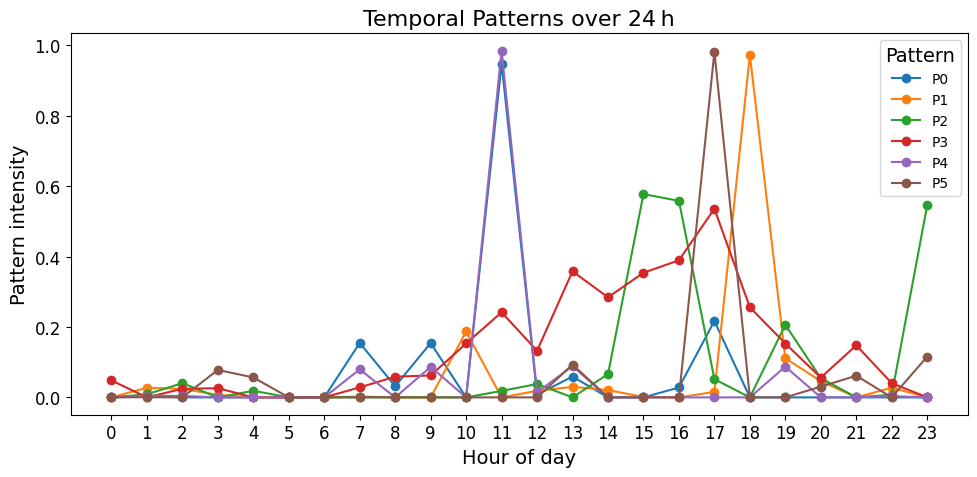

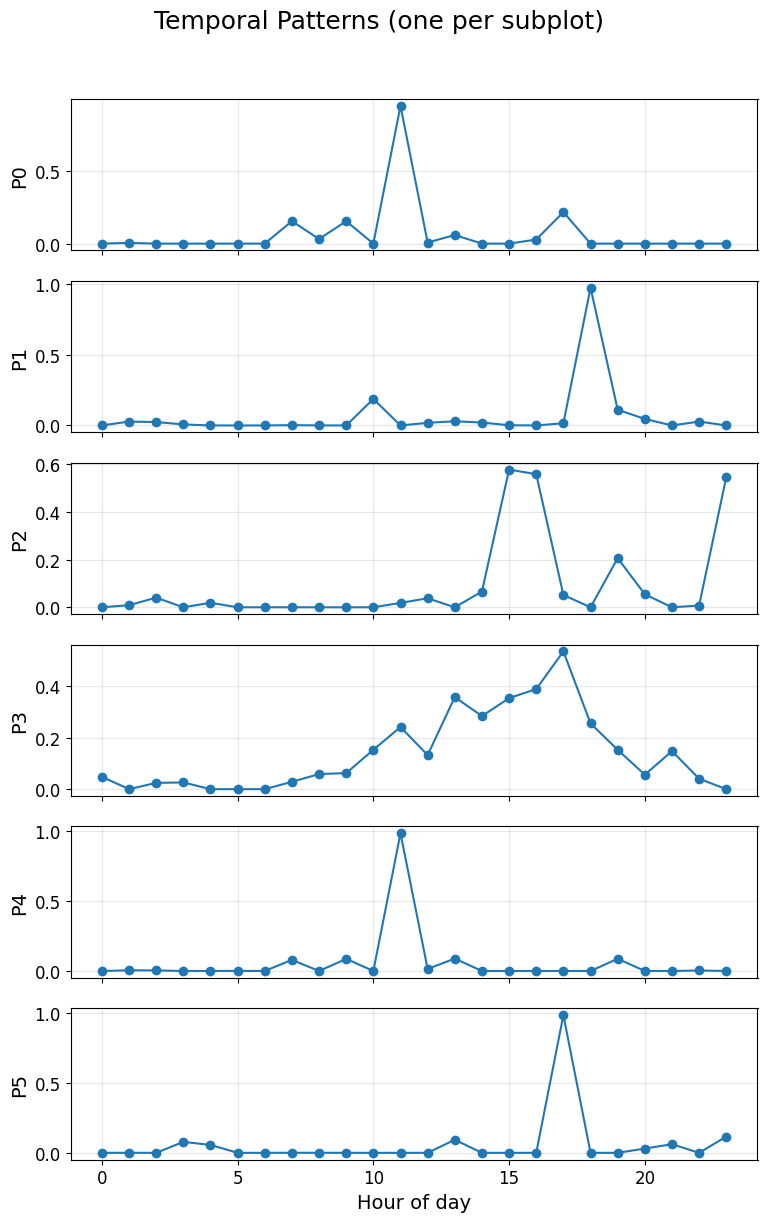

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# assume time_factor is shape [24, n_patterns]
n_hours, n_patterns = time_factor.shape
hours = np.arange(n_hours)
patterns = [f"P{p}" for p in range(n_patterns)]

# put into a DataFrame for convenience
df = pd.DataFrame(time_factor, index=hours, columns=patterns)

# 1) Overlayed on a single plot
plt.figure(figsize=(10, 5))
for p in patterns:
    plt.plot(df.index, df[p], marker="o", label=p)
plt.xlabel("Hour of day")
plt.ylabel("Pattern intensity")
plt.title("Temporal Patterns over 24 h")
plt.xticks(hours)
plt.legend(title="Pattern", bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

# 2) Or as small multiples (one subplot per pattern)
fig, axes = plt.subplots(n_patterns, 1, figsize=(8, 2*n_patterns), sharex=True)
for ax, p in zip(axes, patterns):
    ax.plot(df.index, df[p], marker="o")
    ax.set_ylabel(p)
    ax.grid(True, alpha=0.3)
axes[-1].set_xlabel("Hour of day")
fig.suptitle("Temporal Patterns (one per subplot)", y=1.02)
plt.tight_layout()
plt.show()

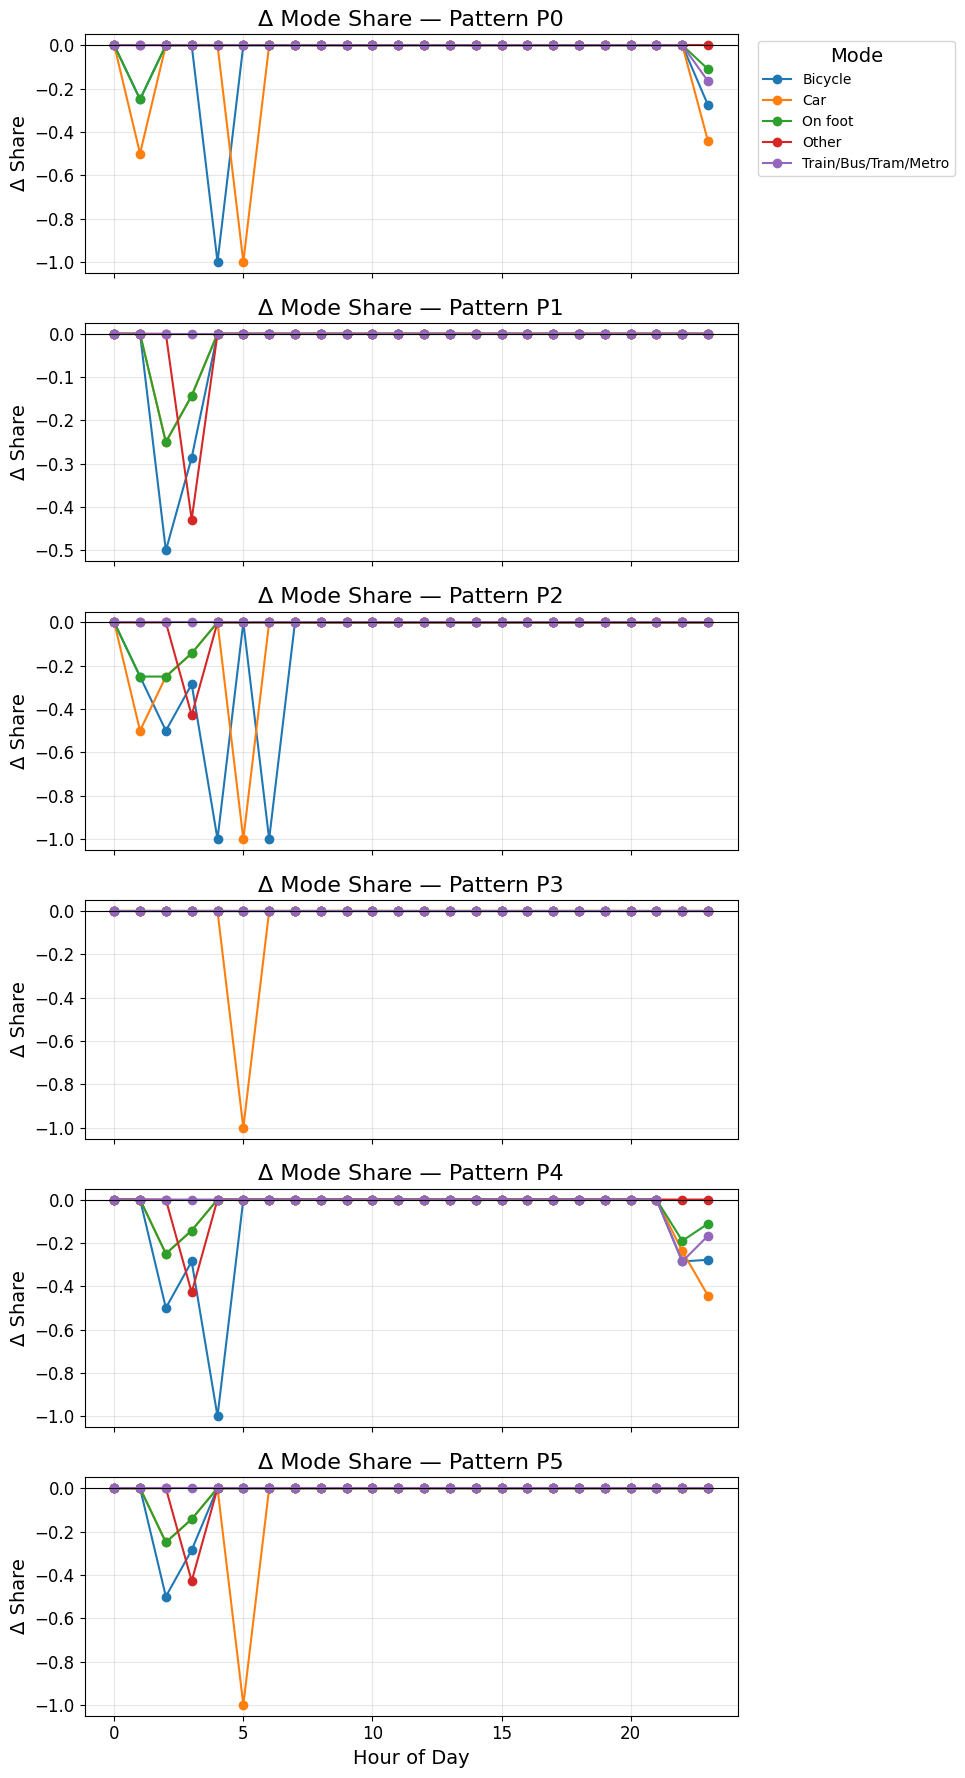

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# — assume you already have:
#    filtered_data: a DataFrame with at least these columns:
#       - 'hour_of_day' (int 0–23)
#       - 'mode_of_transport_desc' (e.g. 'Car','Bike',…)
#       - 'temporal_pattern_P0', 'temporal_pattern_P1', … (one col per pattern)

# 0) helpers & metadata
hours = np.arange(24)
modes = sorted(filtered_data['mode_of_transport_desc'].unique())
temporal_cols = [
    c for c in filtered_data.columns if c.startswith("temporal_pattern_")]
patterns = [c.replace("temporal_pattern_", "") for c in temporal_cols]

# 1) Weighted counts per (pattern, hour, mode)
pattern_hour_mode = {}
for col in temporal_cols:
    grp = (
        filtered_data
        .groupby(['hour_of_day', 'mode_of_transport_desc'])[col]
        .sum()
    )
    pivot = (
        grp
        .unstack(fill_value=0)                     # rows=hour, cols=mode
        .reindex(index=hours, columns=modes, fill_value=0)
    )
    pattern_hour_mode[col] = pivot

# 2) Convert to mode‐shares per (pattern, hour)
pattern_share = {
    col: df.div(df.sum(axis=1), axis=0).fillna(0)
    for col, df in pattern_hour_mode.items()
}

# 3) **Fixed** baseline: unweighted counts → size().unstack()
counts = (
    filtered_data
    .groupby(['hour_of_day', 'mode_of_transport_desc'])
    .size()
    .unstack(fill_value=0)                          # rows=hour, cols=mode
)
baseline = (
    counts
    .div(counts.sum(axis=1), axis=0)                # normalize by hour
    .reindex(index=hours, columns=modes, fill_value=0)
)

# 4) Δ = pattern_share − baseline
delta = {
    col.replace("temporal_pattern_", ""):
    pattern_share[col].subtract(baseline, fill_value=0)
    for col in temporal_cols
}

# 5) Plot small multiples: one panel per pattern
n = len(patterns)
fig, axes = plt.subplots(n, 1, figsize=(10, 3*n), sharex=True)
if n == 1:
    axes = [axes]

for ax, pat in zip(axes, patterns):
    dfΔ = delta[pat]
    for mode in modes:
        ax.plot(hours, dfΔ[mode], marker='o', label=mode)
    ax.axhline(0, color='k', lw=0.8)
    ax.set_title(f"Δ Mode Share — Pattern {pat}")
    ax.set_ylabel("Δ Share")
    ax.grid(alpha=0.3)

axes[-1].set_xlabel("Hour of Day")
axes[0].legend(title="Mode", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

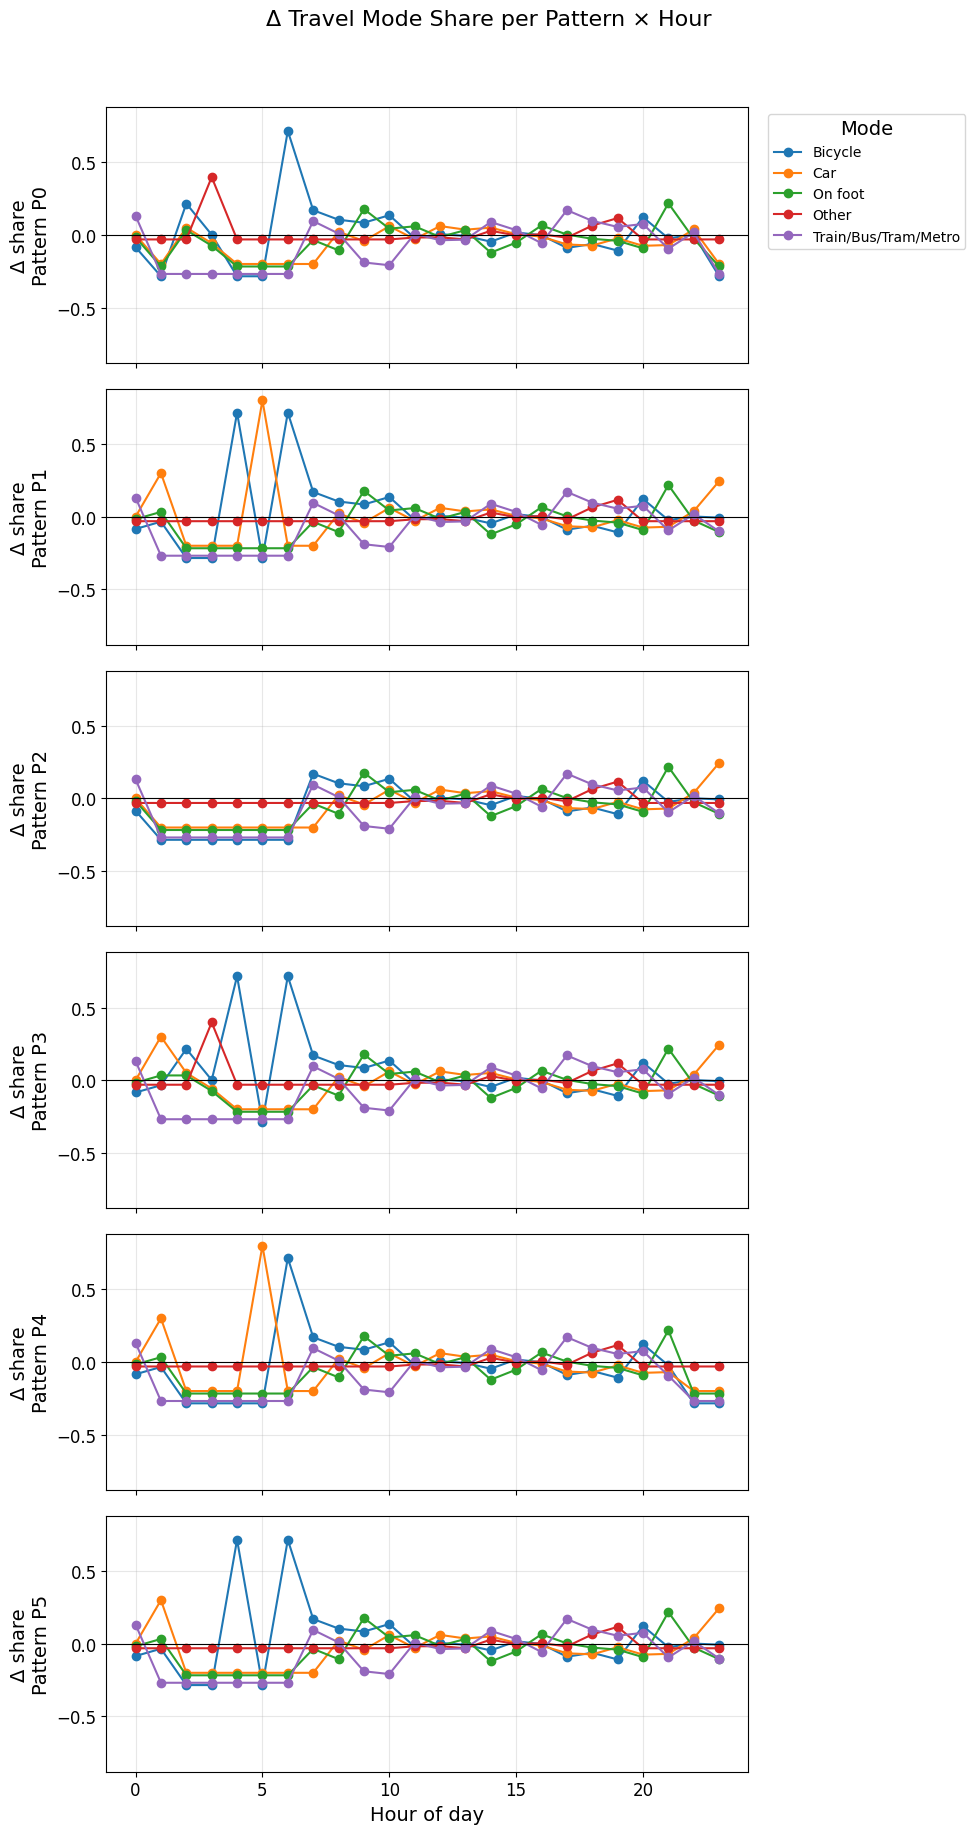

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# assume filtered_data + temporal_pattern_P* columns already exist

hours = np.arange(24)
modes = sorted(filtered_data['mode_of_transport_desc'].unique())
temporal_cols = sorted(
    [c for c in filtered_data.columns if c.startswith("temporal_pattern_")])
patterns = [c.replace("temporal_pattern_", "") for c in temporal_cols]
n_patterns = len(patterns)

# 1) build weighted counts per (hour,mode) for each pattern
pattern_hour_mode = {}
for col in temporal_cols:
    grp = (
        filtered_data
        .groupby(['hour_of_day', 'mode_of_transport_desc'])[col]
        .sum()
    )
    pivot = (
        grp
        .unstack(fill_value=0)
        .reindex(index=hours, columns=modes, fill_value=0)
    )
    pattern_hour_mode[col] = pivot

# 2) compute mode‐shares per pattern×hour
pattern_share = {
    col: df.div(df.sum(axis=1), axis=0).fillna(0)
    for col, df in pattern_hour_mode.items()
}

# 3) compute **global** baseline once
baseline_global = (
    filtered_data['mode_of_transport_desc']
    .value_counts(normalize=True)
)

# 4) Δ = pattern_share − baseline_global
delta = {
    col.replace("temporal_pattern_", ""):
    pattern_share[col].subtract(baseline_global, axis=1).fillna(0)
    for col in temporal_cols
}

# 5) small multiples
fig, axes = plt.subplots(n_patterns, 1,
                         figsize=(10, 3*n_patterns),
                         sharex=True)
if n_patterns == 1:
    axes = [axes]

# find symmetric y‐lim so zero is centered
all_vals = np.hstack([df.values.flatten() for df in delta.values()])
m = np.nanmax(np.abs(all_vals))

for ax, pat in zip(axes, patterns):
    dfΔ = delta[pat]
    for mode in modes:
        ax.plot(hours, dfΔ[mode], '-o', label=mode)
    ax.axhline(0, color='k', lw=0.8)
    ax.set_ylabel(f"Δ share\nPattern {pat}")
    ax.set_ylim(-m*1.1, m*1.1)   # symmetric y axis
    ax.grid(alpha=0.3)

axes[-1].set_xlabel("Hour of day")
axes[0].legend(title="Mode", bbox_to_anchor=(1.02, 1), loc="upper left")
fig.suptitle("Δ Travel Mode Share per Pattern × Hour", y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

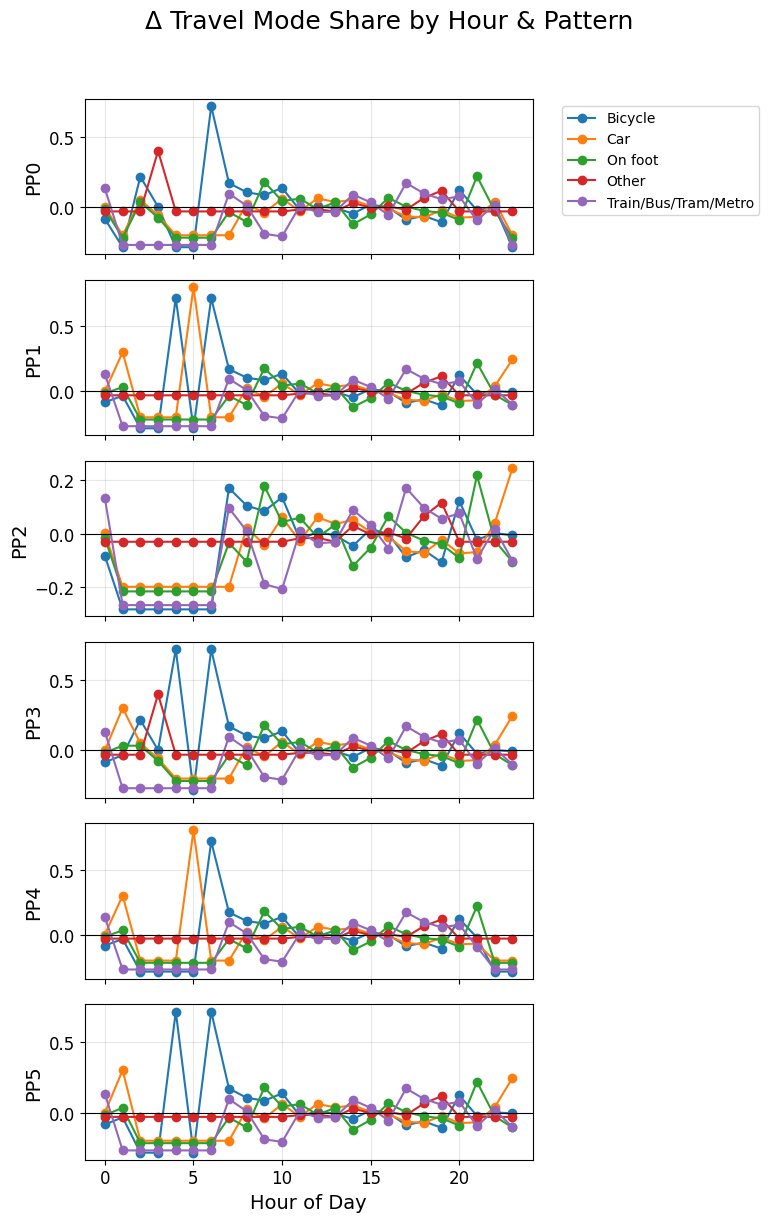

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- 0) load your data -----------------------
# filtered_data = pd.read_csv(...)

# --- identify which columns hold the temporal‐pattern intensities
temporal_cols = [c for c in filtered_data.columns
                 if c.startswith("temporal_pattern_P")]

# --- 1) For each pattern, for each hour, for each mode: weighted trip‐counts
#     This gives you a small table for each pattern of shape (24 hours × N_modes)
pattern_hour_counts = {}
for pat in temporal_cols:
    # sum up the pat‐intensity per (hour,mode)
    df = (
        filtered_data
        .groupby(['hour_of_day', 'mode_of_transport_desc'])[pat]
        .sum()
        .unstack(fill_value=0)
    )
    pattern_hour_counts[pat] = df

# --- 2) Turn those counts into shares **within each hour** for that pattern
pattern_hour_shares = {
    pat: df.div(df.sum(axis=1), axis=0).fillna(0)
    for pat, df in pattern_hour_counts.items()
}

# --- 3) Compute the global baseline (all trips) mode‐share once
baseline = (
    filtered_data['mode_of_transport_desc']
    .value_counts(normalize=True)
)

# --- 4) For each pattern, subtract baseline from each hour‐share
pattern_hour_delta = {
    pat: shares.sub(baseline, axis=1).fillna(0)
    for pat, shares in pattern_hour_shares.items()
}

# --- 5) Plot as “small multiples”: one subplot per pattern ------------
n = len(temporal_cols)
fig, axes = plt.subplots(n, 1,
                         figsize=(8, 2*n),
                         sharex=True)

for ax, pat in zip(axes, temporal_cols):
    df = pattern_hour_delta[pat]
    hours = df.index                    # 0…23
    for mode in df.columns:
        ax.plot(hours,
                df[mode],
                marker='o',
                label=mode)
    ax.axhline(0, color='k', lw=0.8)
    ax.set_ylabel(pat.replace("temporal_pattern_", "P"))
    ax.grid(alpha=0.3)

axes[-1].set_xlabel("Hour of Day")
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
fig.suptitle("Δ Travel Mode Share by Hour & Pattern", y=1.02)
plt.tight_layout()
plt.show()